#AutoTS набор данных с производными

##Загрузка пакетов

Опускаемся по версии pandas т.к. в пакете auto-ts в 1068 строке файла _init_.py применяется метод append к DataFrame. Метод был убран из pandas начиная со 2ой версии. При использовании pandas 2ой версии пакет auto-ts полноценно работает только с данными не превышающими 1000 строк

In [ ]:
!pip install gputil
!pip -q install auto-ts pmdarima --no-deps --ignore-installed
!pip install 'fsspec>=0.3.3'
!pip install statsmodels --upgrade
!pip install pmdarima
!pip install 'pandas==1.5.3'

In [ ]:
import GPUtil as GPU
import pandas as pd
import numpy as np
import math
from google.colab import drive
import time
import time
from datetime import datetime, date, time
import os
from auto_ts import auto_timeseries
from auto_ts import print_ts_model_stats
import matplotlib.pyplot as plt

Данные заказчика загружаем с Гугл диска

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Определение функций и подготовка данных

Функции для преобразования данных в датасете

In [ ]:
def stripsec(str1):
  return str1.rstrip('0').rstrip(':')

def extdate(str1):
  #return str1.partition(' ')[0]
  return str1.normalize()

def exttime(str1):
  return str1.partition(' ')[2]

def ordday(str1):
  return str1.toordinal()

def tosin(x):
  return math.sin(math.radians(x))

def tocos(x):
  return math.cos(math.radians(x))

def datetime64(str1):
  return np.datetime64(str1[6:10] + '-' + str1[3:5] + '-' + str1[0:2] + str1[10:])

def datehour(str1):
  return np.datetime64(str1[6:10] + '-' + str1[3:5] + '-' + str1[0:2] + str1[10:14] + '00:00')

def handleset(ss):
  df = base0[ss]
  df = df.assign(DateTime = df['Date & Time Stamp'].apply(datetime64))
  df = df.assign(Ordday = df['DateTime'].apply(ordday))
  df = df.assign(Date = df['DateTime'].apply(extdate))
#от угловых величин переходим к синусам и косинусам для направления ветра изменяющегося от 0 до 360 градусов и к синусу для среднеквадратичного отклонения, которое обычно близко к 0
  df = df.assign(Sin8Avg = df['CH8Avg'].apply(tosin))
  df = df.assign(Cos8Avg = df['CH8Avg'].apply(tocos))
  df = df.assign(Sin8SD = df['CH8SD'].apply(tosin))
  df = df.assign(DateHour = df['Date & Time Stamp'].apply(datehour))
#рассчитываем производные для скорости ветра, температуры, давления и влажности
  for i in (numch[ss],9,10,11):
    df[f'dCH{i}Avg'] = df[f'CH{i}Avg'].diff()
  return df


Создаем таблицы, списки полей таблиц, загружаем данные в таблицу и производим преобразования

In [ ]:
#составляем список вышек
sites = ['Manily','Ust-Hayriuzovo','Palana','Ossora','Tilichiki','Ust-Kamchatsk']
chann = list()
numch = {}
base = {}
base0 = {}
meanbase = {}
#составляем список каналов
for i in range (15):
  for j in ('Avg','SD','Max','Min'):
    chann.append(f'CH{i+1}{j}')
chann0 = ['DateTime',*chann]
chann1 = ['DateHour',*chann]
#номера каналов с которых мы будем брать силу ветра для каждой из вышек
numch[sites[0]] = 14
numch[sites[1]] = 5
numch[sites[2]] = 5
numch[sites[3]] = 5
numch[sites[4]] = 14
numch[sites[5]] = 14
ind = {name: chan for chan, name in enumerate(chann)}
#загружаем данные заказчика в DataFrame
for site in sites:
  base0[site] = pd.read_csv(f'/content/drive/MyDrive/Traineeship/VIK_{site}.txt', sep='\t', skiprows = 170, encoding = 'iso-8859-1', decimal = ',')
  base0[site] = handleset(site)

##Исследование данных

Определяем периоды непрерывных данных для разных вышек

In [ ]:
lbase = {}
for site in sites:
  lbase[site] = base0[site].groupby('Date').count()
  ddate = {'Date':[],'Count':[]}
  raw = []
  for i in pd.date_range(pd.to_datetime(base0[site]['DateTime'].min()).normalize(),pd.to_datetime(base0[site]['DateTime'].max()).normalize()):
    raw.append(i)
    ddate['Date'].append(i)
    ddate['Count'].append(len(base0[site].loc[base0[site]['Ordday'] == i.toordinal()]))
  lbase[site] =  pd.DataFrame(data = ddate,index = raw)

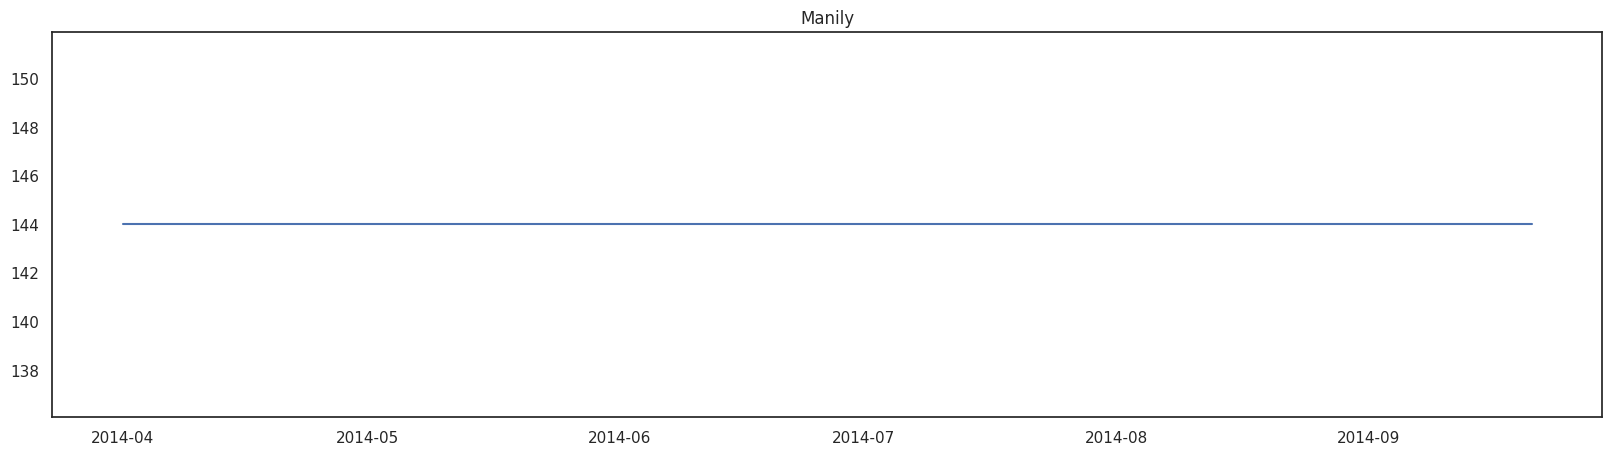

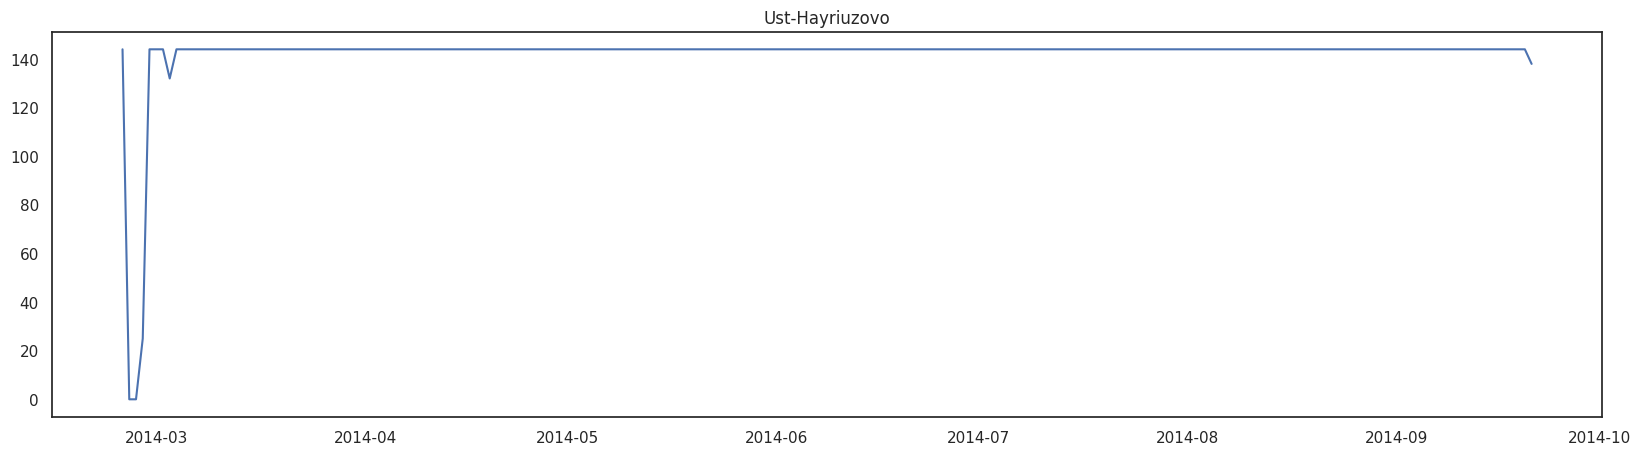

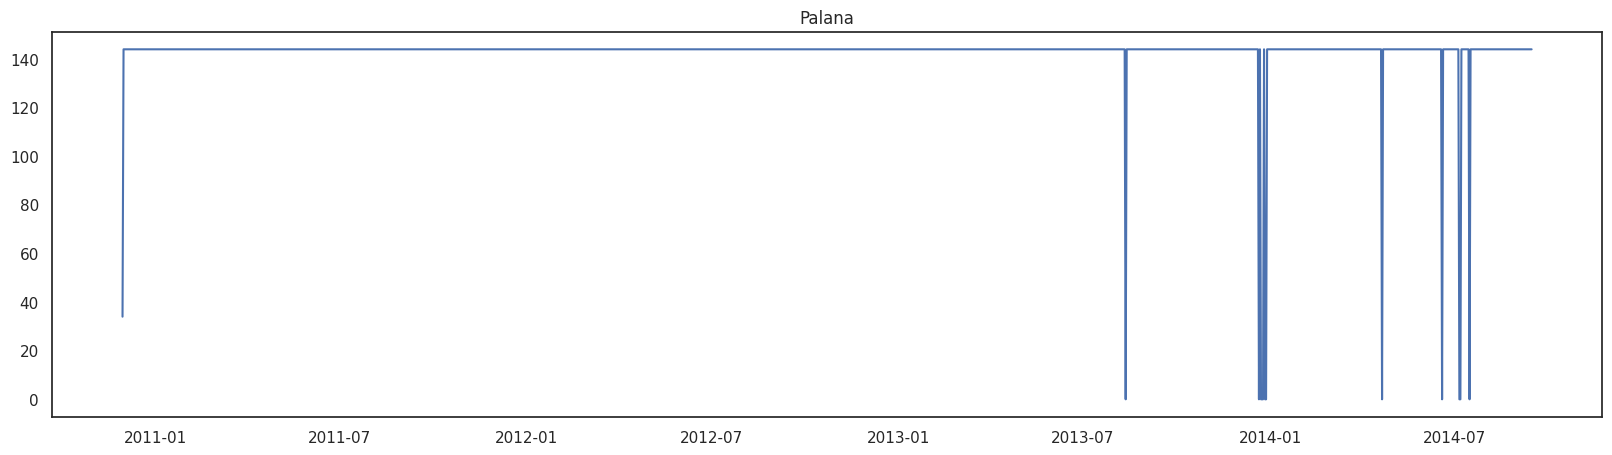

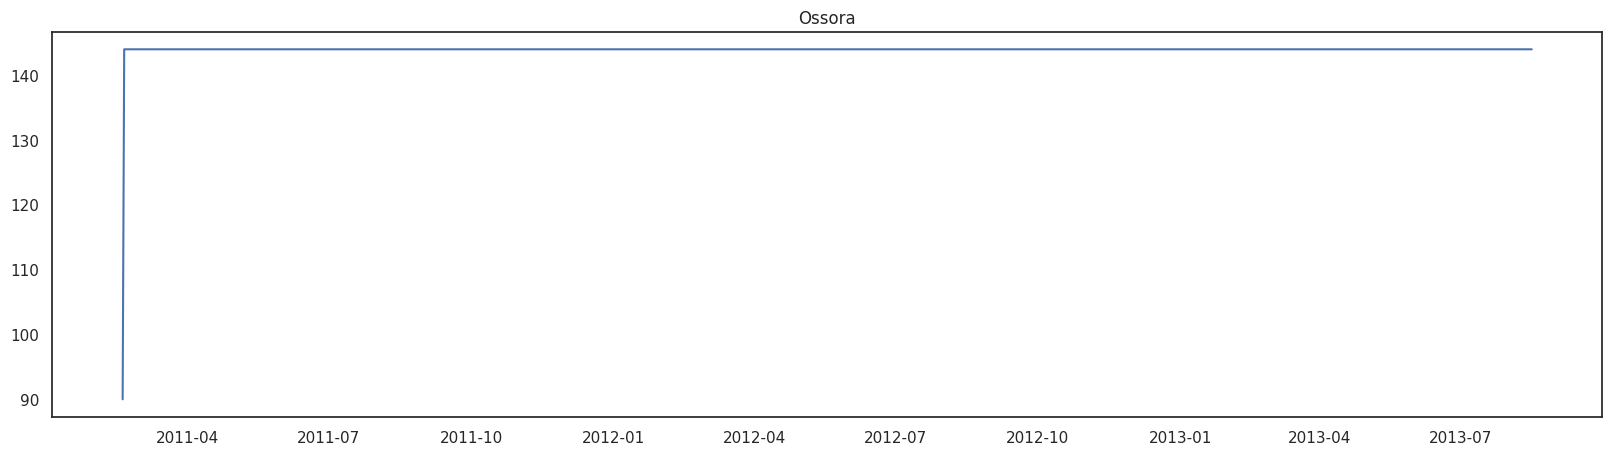

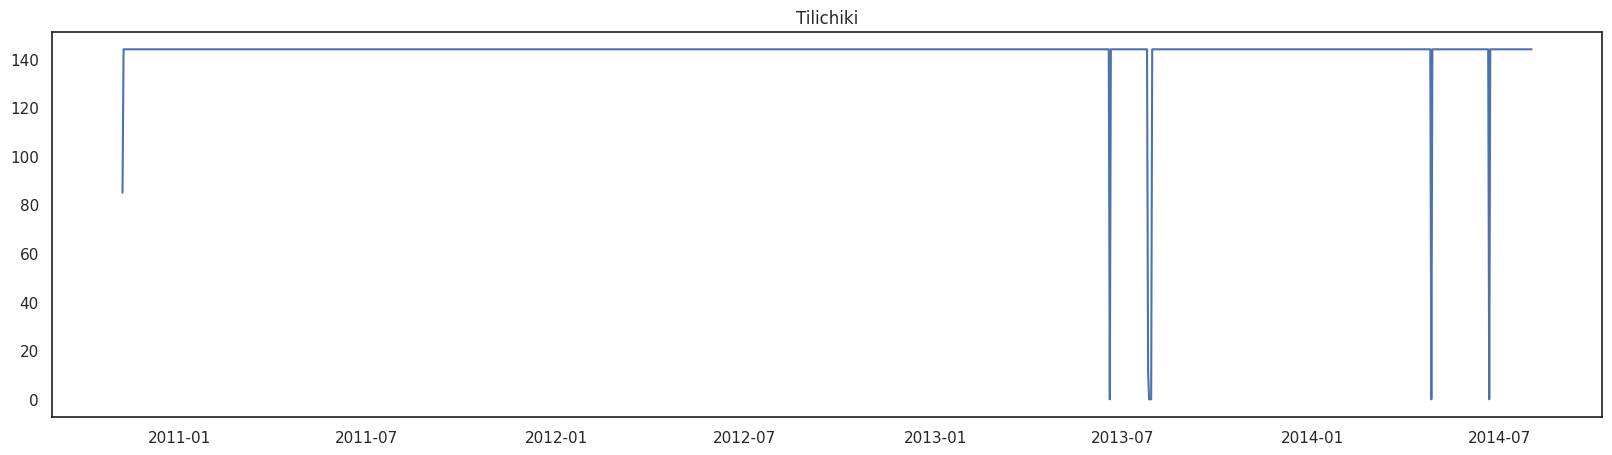

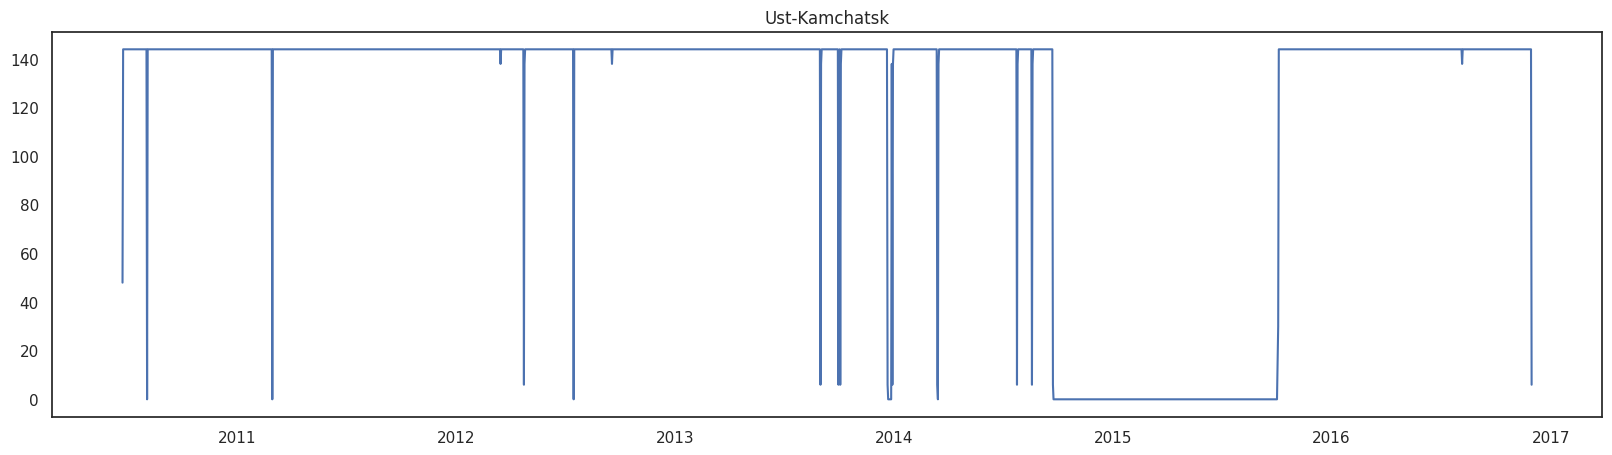

In [ ]:
for site in sites:
  plt.figure(figsize=(20, 5))
  plt.plot(lbase[site]['Date'], lbase[site]['Count'])
  plt.title(site)
  plt.show()

 Определяем периоды достоверных данных, при падении напряжения питания сети ниже 8 вольт данные могут быть недостоверны. На вышке Усть-Хайрюзово вольтметр не был подключён

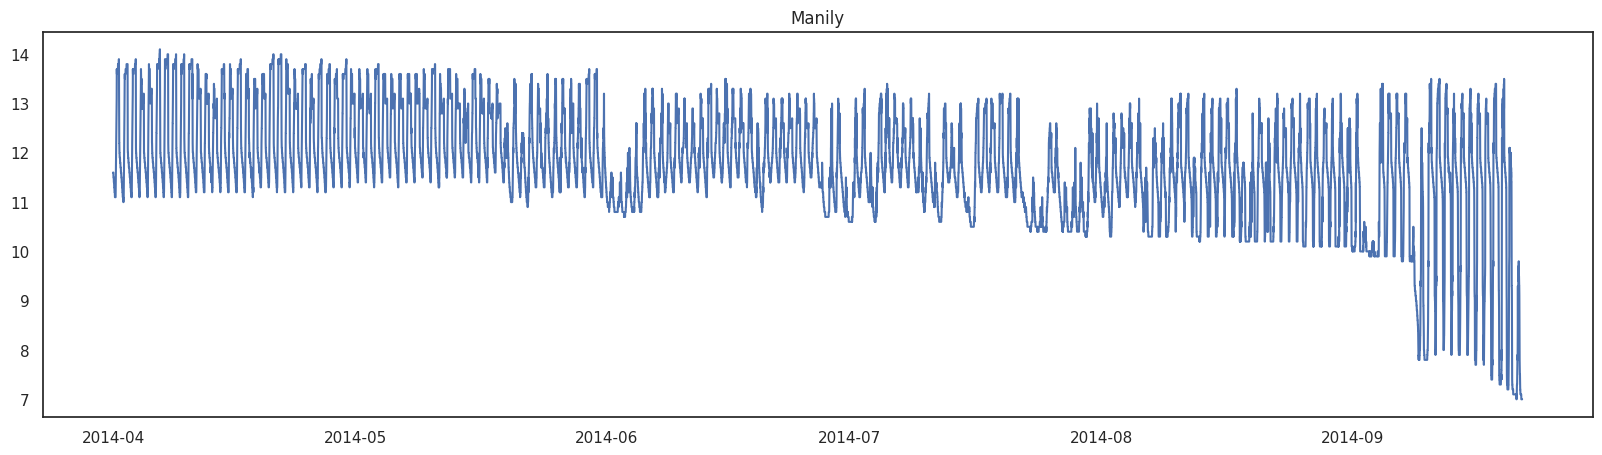

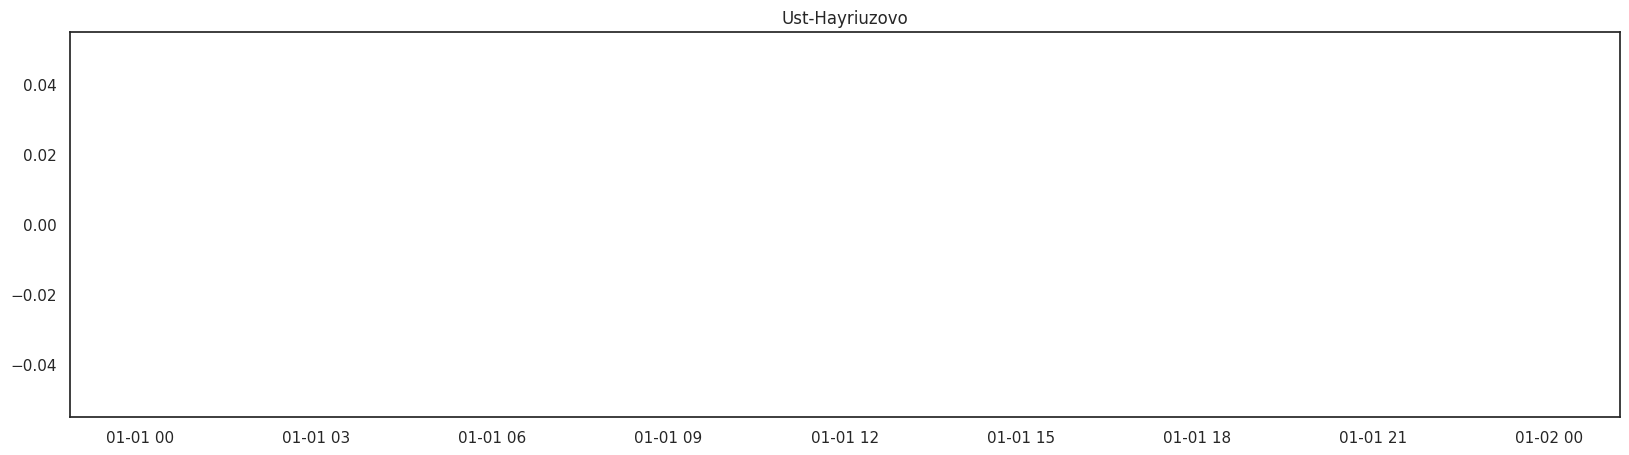

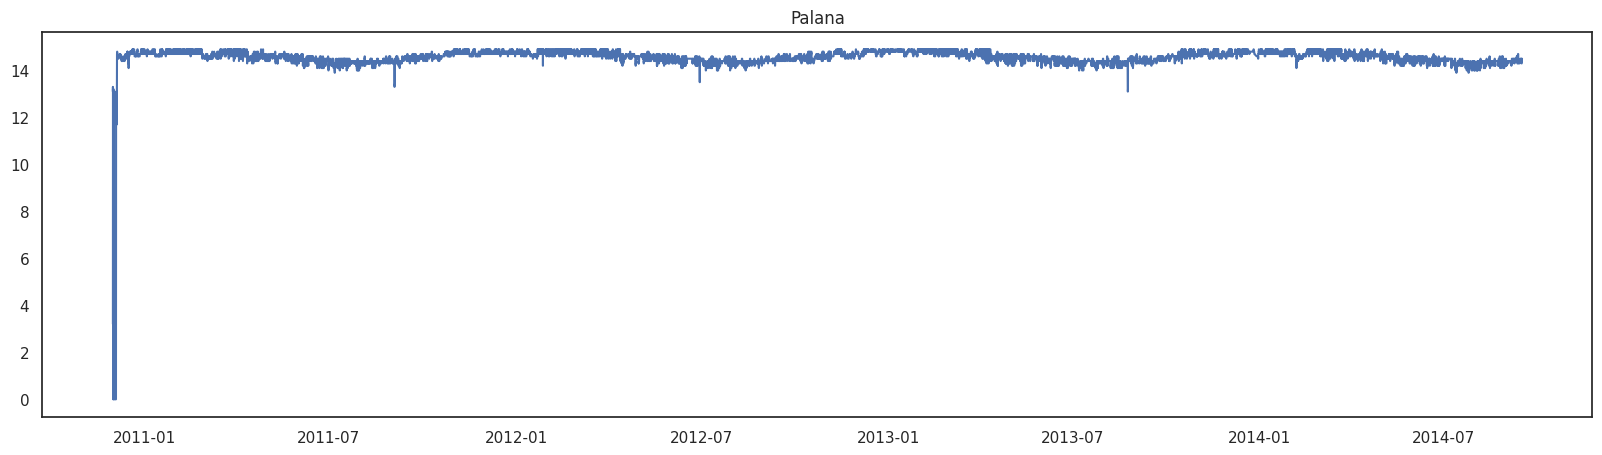

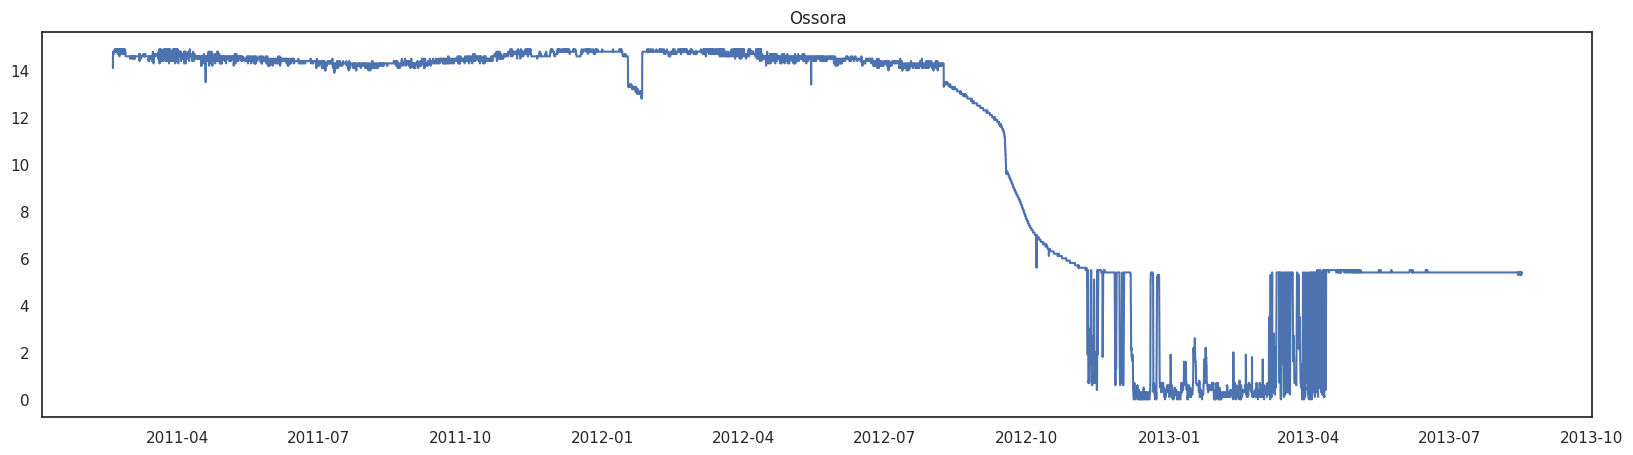

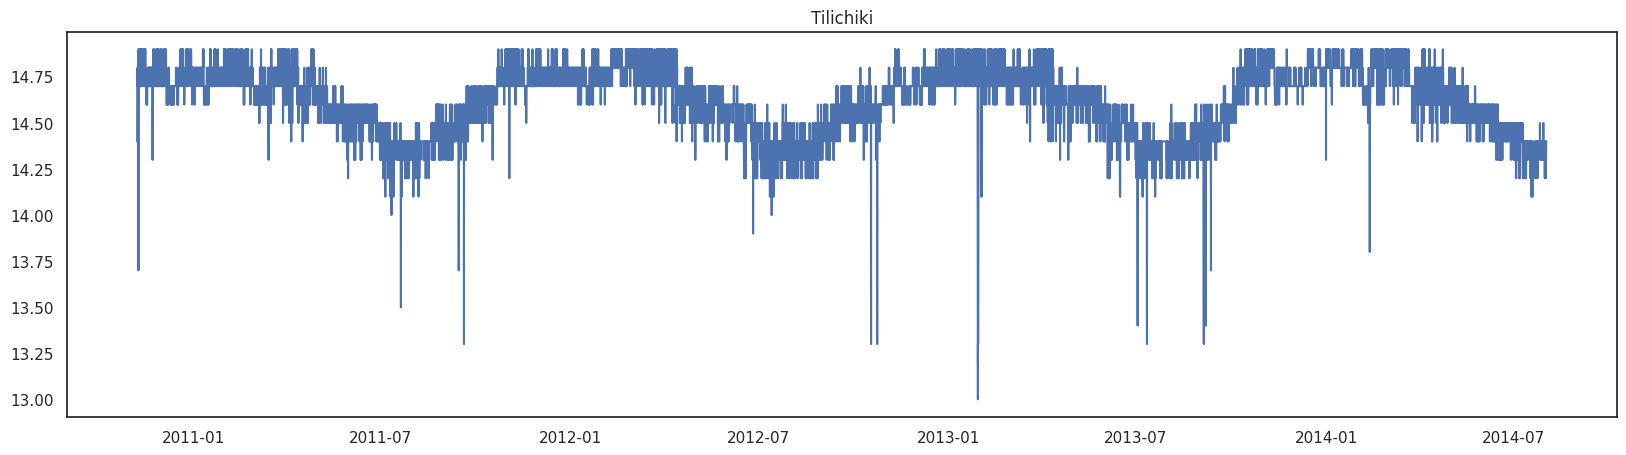

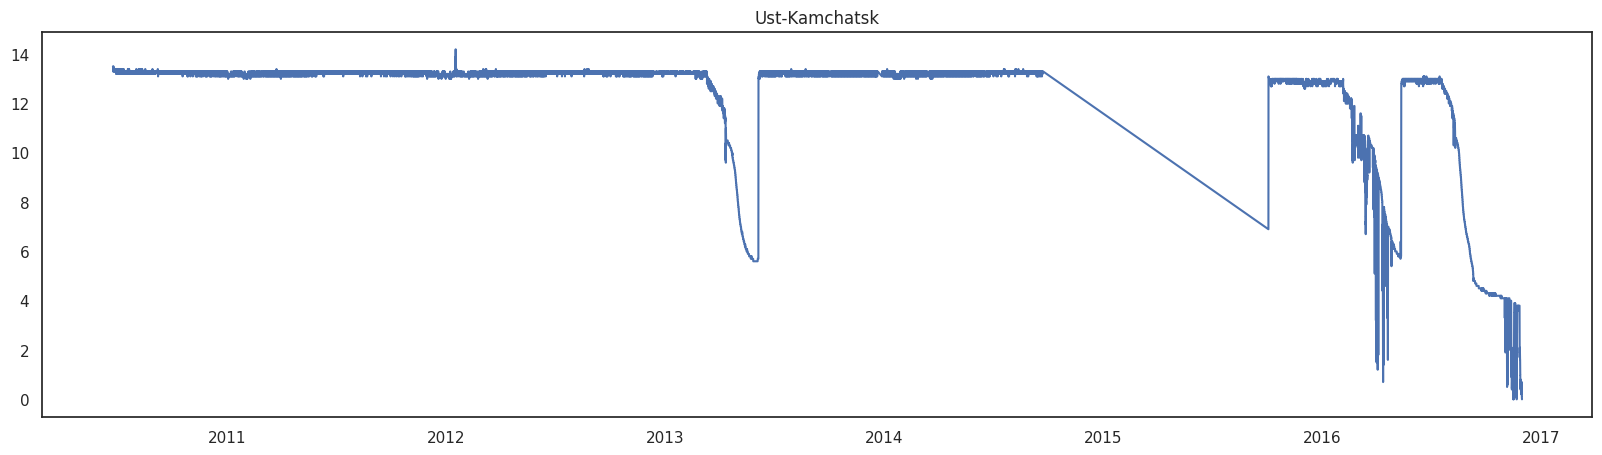

In [ ]:
for site in sites:
  plt.figure(figsize=(20, 5))
  plt.plot(base0[site]['DateTime'], base0[site]['CH12Avg'])
  plt.title(site)
  plt.show()

Изучим данные на вышке Манилы. Судя по графикам падение напряжение питания ниже 8 воль (график CH12Avg) влияет только на барометр (график CH10Avg), характер других графиков не меняется

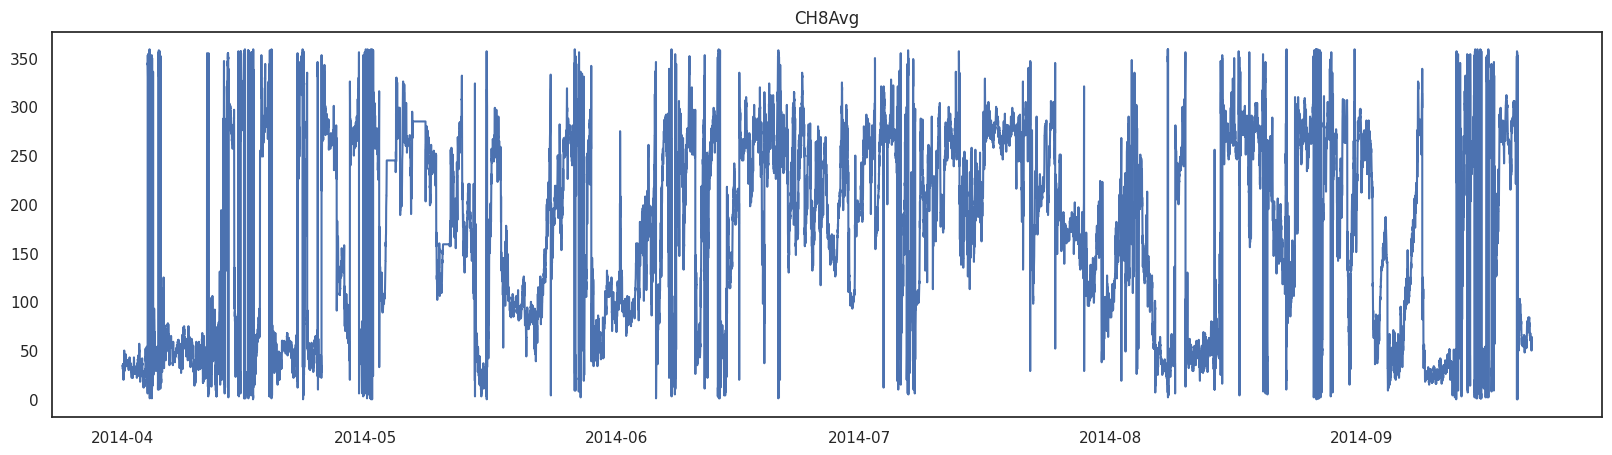

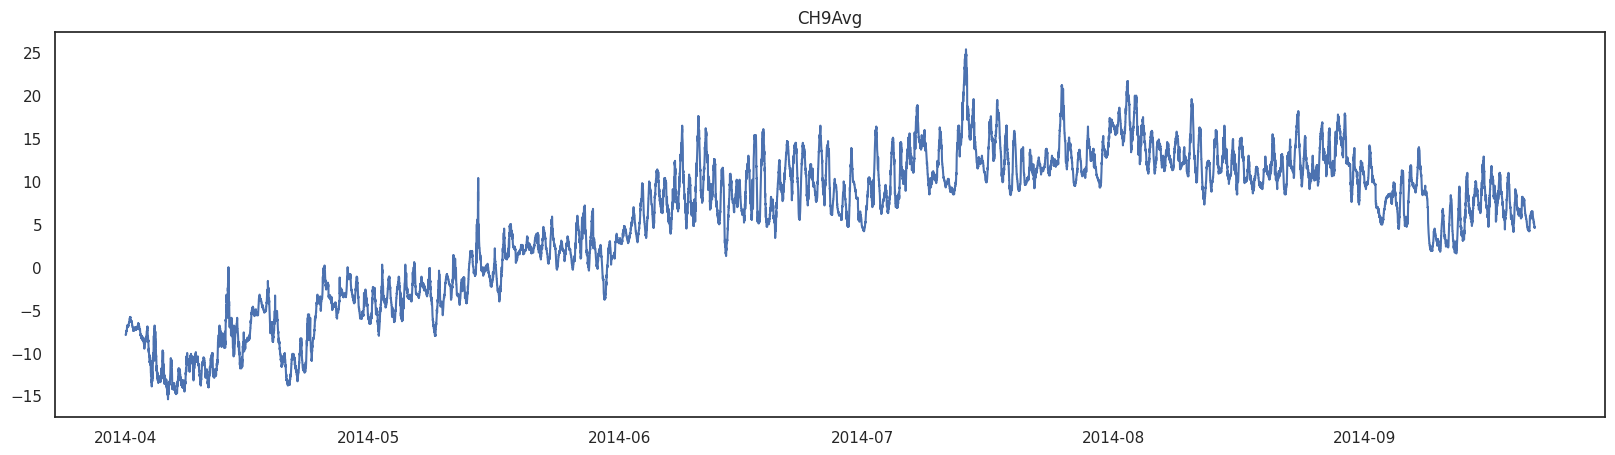

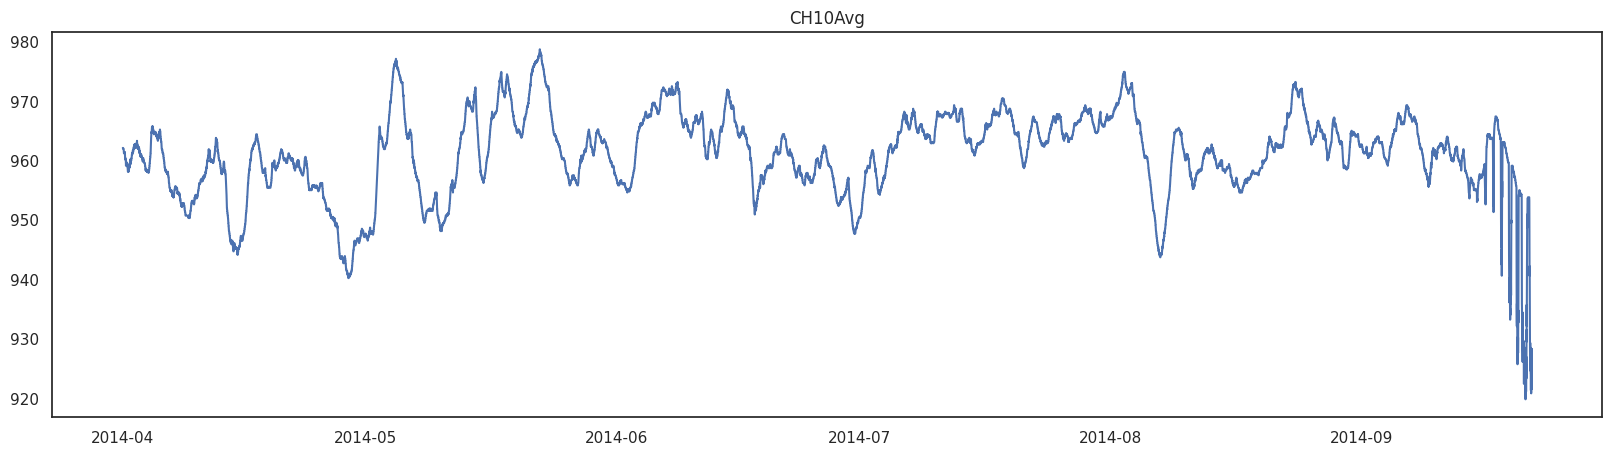

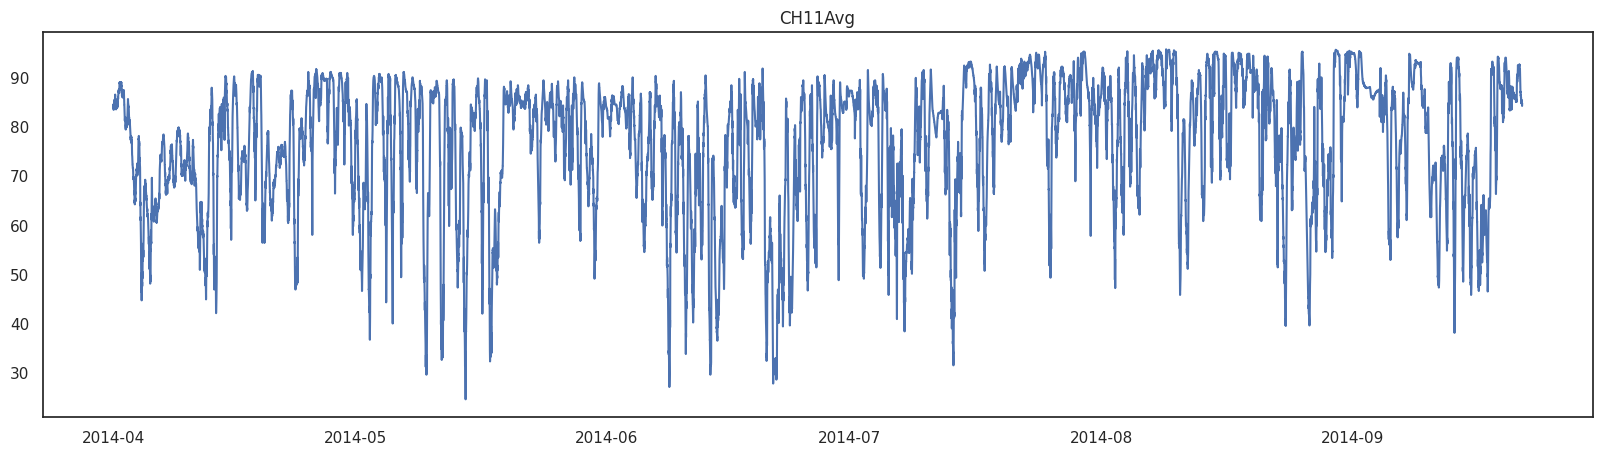

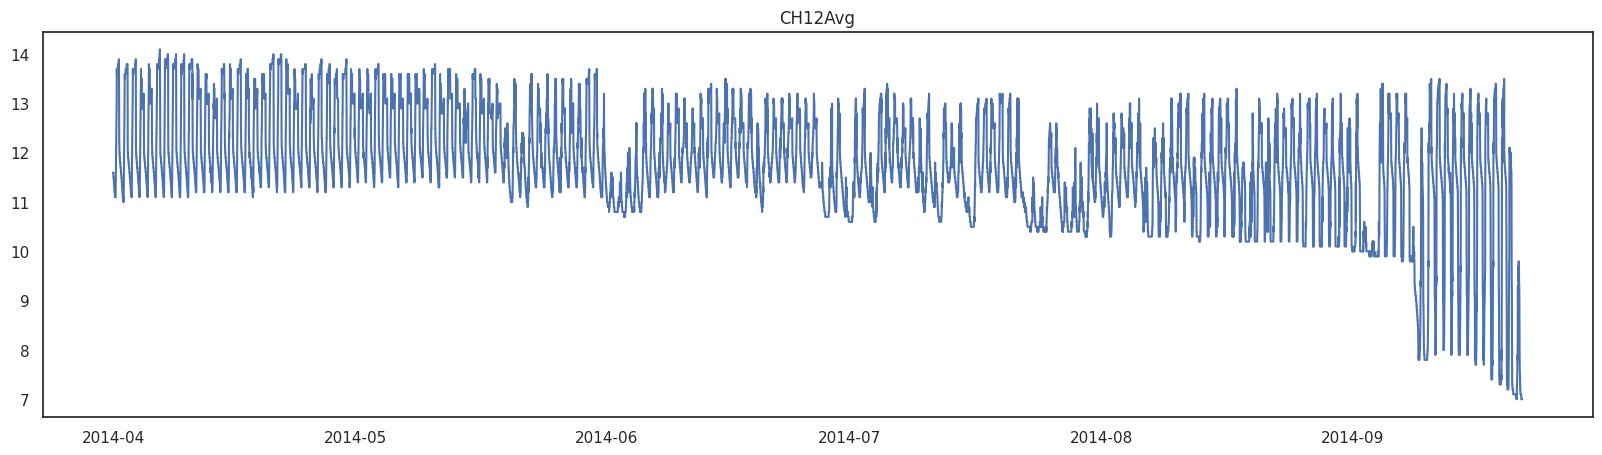

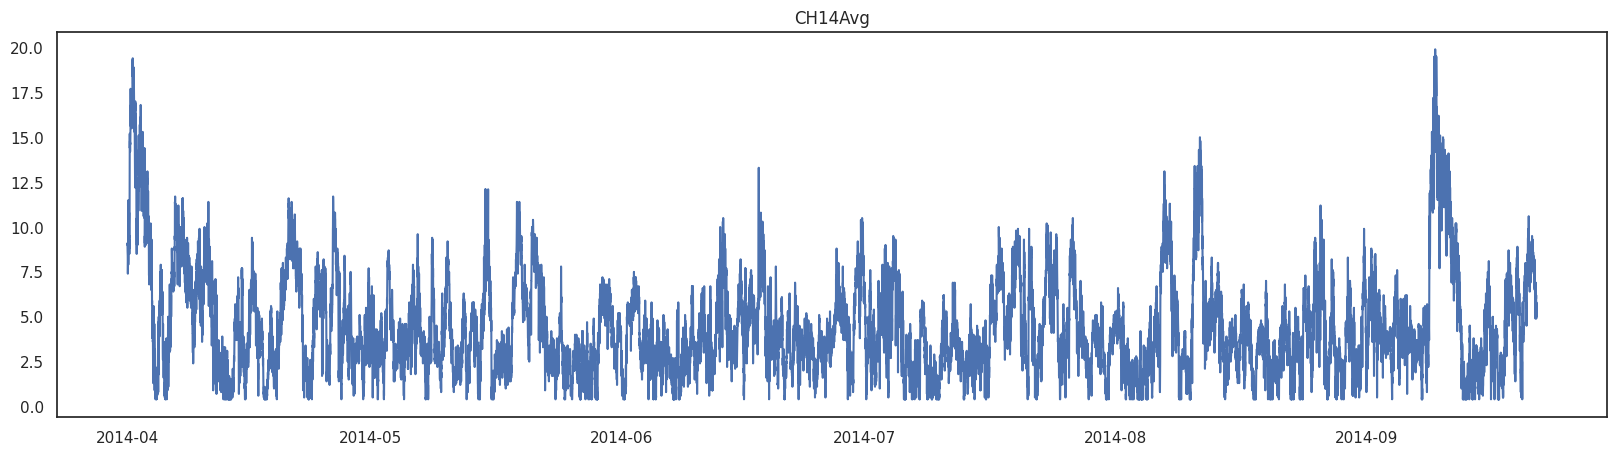

In [ ]:
for ch in ['CH8Avg','CH9Avg','CH10Avg','CH11Avg','CH12Avg','CH14Avg']:
  plt.figure(figsize=(20, 5))
  plt.plot(base0['Manily']['DateTime'], base0['Manily'][ch])
  plt.title(ch)
  plt.show()

##Эксперименты

###Эксперимент 1

Для первого эксперимента берем данные по вышке Манилы,  единственной где есть замеры давления и влажности воздуха, берем данные с корректными показаниями приборов

In [ ]:
data = base0[sites[0]].loc[(base0[sites[0]]['Date'] >= np.datetime64('2014-04-01'))&(base0[sites[0]]['Date'] <= np.datetime64('2014-09-08'))][['DateTime','CH14Avg','dCH14Avg','CH14SD','Sin8Avg','Cos8Avg','Sin8SD','CH9Avg','dCH9Avg','CH9SD','CH10Avg','dCH10Avg','CH10SD','CH11Avg','dCH11Avg','CH11SD']].copy(deep=True).reset_index()
data = data.rename(columns={'CH14Avg':'WindAvg','dCH14Avg':'dWindAvg','CH14SD':'WindSD','CH8Avg':'DirAvg','Sin8SD':'DirSD','CH9Avg':'TempAvg','dCH9Avg':'dTempAvg','CH9SD':'TempSD','CH10Avg':'PresAvg','dCH10Avg':'dPresAvg','CH10SD':'PresSD','CH11Avg':'HumAvg','dCH11Avg':'dHumAvg','CH11SD':'HumSD'})
del data['index']


In [ ]:
data

DateTime  WindAvg  dWindAvg  WindSD   Sin8Avg   Cos8Avg  \
0     2014-04-01 00:00:00      9.0       0.0     0.8  0.559193  0.829038   
1     2014-04-01 00:10:00      9.1       0.1     0.8  0.573576  0.819152   
2     2014-04-01 00:20:00      8.7      -0.4     1.0  0.529919  0.848048   
3     2014-04-01 00:30:00      8.8       0.1     0.9  0.515038  0.857167   
4     2014-04-01 00:40:00      8.6      -0.2     1.1  0.559193  0.829038   
...                   ...      ...       ...     ...       ...       ...   
23179 2014-09-08 23:10:00     13.3       0.9     1.6  0.422618  0.906308   
23180 2014-09-08 23:20:00     12.4      -0.9     1.7  0.453990  0.891007   
23181 2014-09-08 23:30:00     12.8       0.4     1.8  0.469472  0.882948   
23182 2014-09-08 23:40:00     12.8       0.0     2.0  0.469472  0.882948   
23183 2014-09-08 23:50:00     12.7      -0.1     2.0  0.484810  0.874620   

          DirSD  TempAvg  dTempAvg  TempSD  PresAvg  dPresAvg  PresSD  HumAvg  \
0      0.087156     -7.9       0.0     0.1    962.1       0.0     0.2    83.9   
1      0.087156     -7.9       0.0     0.1    962.1       0.0     0.2    83.9   
2      0.087156     -7.9       0.0     0.1    962.1       0.0     0.2    84.1   
3      0.104528     -7.9       0.0     0.1    962.1       0.0     0.2    84.3   
4      0.104528     -7.8       0.1     0.1    962.1       0.0     0.2    84.5   
...         ...      ...       ...     ...      ...       ...     ...     ...   
23179  0.139173      2.9       0.0     0.0    957.7      -0.2     0.2    93.1   
23180  0.139173      2.9       0.0     0.1    957.7       0.0     0.2    93.0   
23181  0.190809      2.8      -0.1     0.0    957.7       0.0     0.2    93.0   
23182  0.139173      2.8       0.0     0.0    957.7       0.0     0.2    93.0   
23183  0.156434      2.8       0.0     0.1    957.7       0.0     0.2    93.0   

       dHumAvg  HumSD  
0          0.0    0.4  
1          0.0    0.4  
2          0.2    0.4  
3          0.2    0.4  
4          0.2    0.4  
...        ...    ...  
23179     -0.1    0.3  
23180     -0.1    0.3  
23181      0.0    0.3  
23182      0.0    0.3  
23183      0.0    0.3  

[23184 rows x 16 columns]

In [ ]:
del data['DateTime']

Так как пакет auto-ts может работать только со стандартными интервалами времени,  вместо реальных меток времени подставляем метки с часовыми интервалами, т.е. увеличиваем реальные интервалы в 6 раз

In [ ]:
datetime_series = pd.Series(pd.date_range("2014-01-01", periods=23184, freq="h"))

In [ ]:
data.insert(0,'DateTime',datetime_series)

In [ ]:
data

DateTime  WindAvg  dWindAvg  WindSD   Sin8Avg   Cos8Avg  \
0     2014-01-01 00:00:00      9.0       0.0     0.8  0.559193  0.829038   
1     2014-01-01 01:00:00      9.1       0.1     0.8  0.573576  0.819152   
2     2014-01-01 02:00:00      8.7      -0.4     1.0  0.529919  0.848048   
3     2014-01-01 03:00:00      8.8       0.1     0.9  0.515038  0.857167   
4     2014-01-01 04:00:00      8.6      -0.2     1.1  0.559193  0.829038   
...                   ...      ...       ...     ...       ...       ...   
23179 2016-08-23 19:00:00     13.3       0.9     1.6  0.422618  0.906308   
23180 2016-08-23 20:00:00     12.4      -0.9     1.7  0.453990  0.891007   
23181 2016-08-23 21:00:00     12.8       0.4     1.8  0.469472  0.882948   
23182 2016-08-23 22:00:00     12.8       0.0     2.0  0.469472  0.882948   
23183 2016-08-23 23:00:00     12.7      -0.1     2.0  0.484810  0.874620   

          DirSD  TempAvg  dTempAvg  TempSD  PresAvg  dPresAvg  PresSD  HumAvg  \
0      0.087156     -7.9       0.0     0.1    962.1       0.0     0.2    83.9   
1      0.087156     -7.9       0.0     0.1    962.1       0.0     0.2    83.9   
2      0.087156     -7.9       0.0     0.1    962.1       0.0     0.2    84.1   
3      0.104528     -7.9       0.0     0.1    962.1       0.0     0.2    84.3   
4      0.104528     -7.8       0.1     0.1    962.1       0.0     0.2    84.5   
...         ...      ...       ...     ...      ...       ...     ...     ...   
23179  0.139173      2.9       0.0     0.0    957.7      -0.2     0.2    93.1   
23180  0.139173      2.9       0.0     0.1    957.7       0.0     0.2    93.0   
23181  0.190809      2.8      -0.1     0.0    957.7       0.0     0.2    93.0   
23182  0.139173      2.8       0.0     0.0    957.7       0.0     0.2    93.0   
23183  0.156434      2.8       0.0     0.1    957.7       0.0     0.2    93.0   

       dHumAvg  HumSD  
0          0.0    0.4  
1          0.0    0.4  
2          0.2    0.4  
3          0.2    0.4  
4          0.2    0.4  
...        ...    ...  
23179     -0.1    0.3  
23180     -0.1    0.3  
23181      0.0    0.3  
23182      0.0    0.3  
23183      0.0    0.3  

[23184 rows x 16 columns]

Start of Fit.....
    Target variable given as = WindAvg
Start of loading of data.....
    Inputs: ts_column = DateTime, sep = ,, target = ['WindAvg']
    Using given input: pandas dataframe...
    DateTime column exists in given train data...
    train data shape = (23039, 15)
Alert: Could not detect strf_time_format of DateTime. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


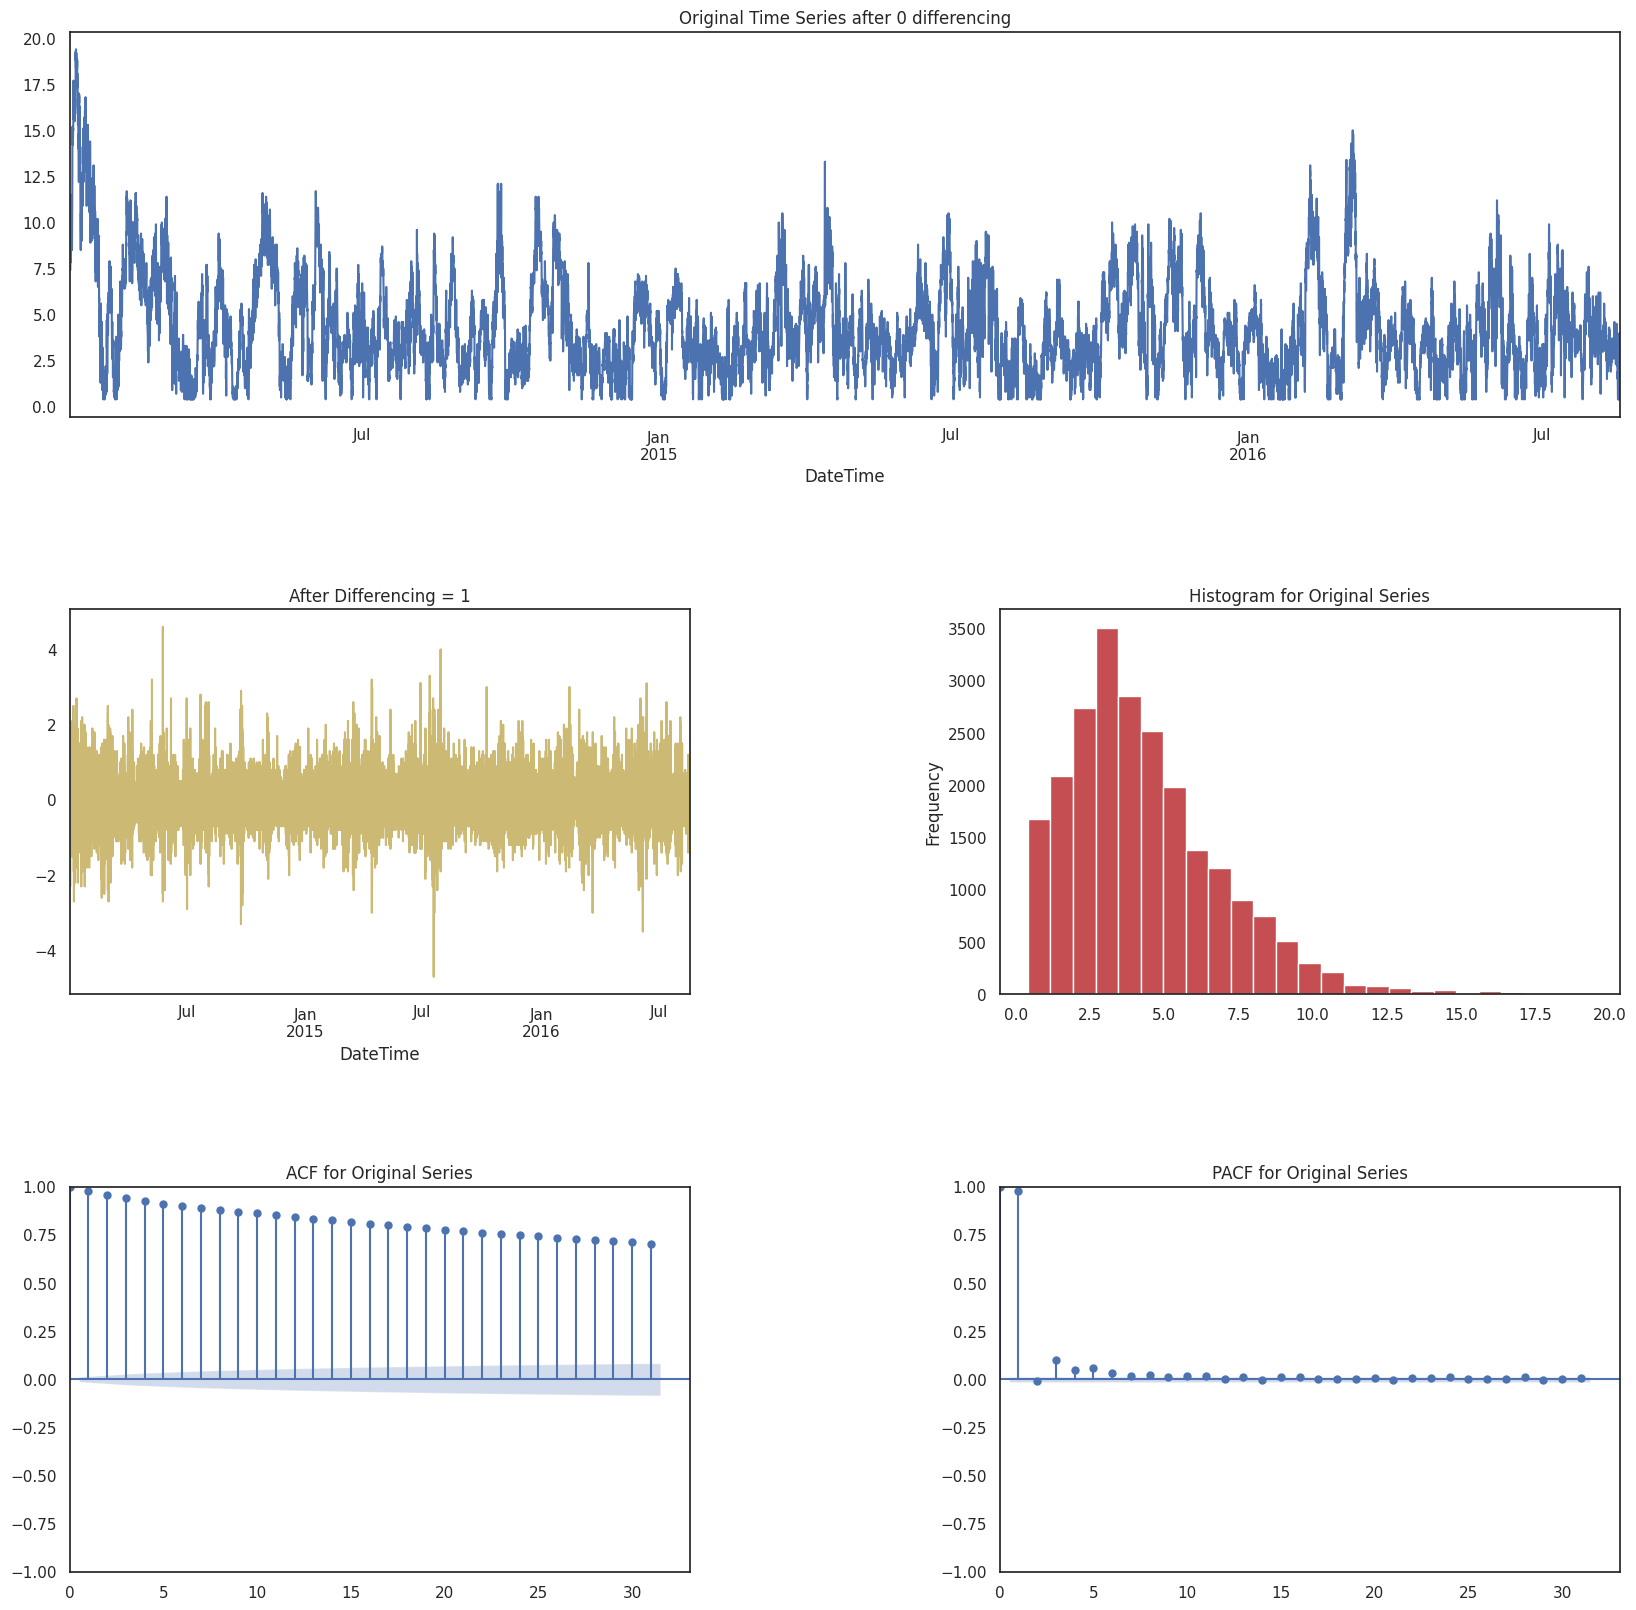

Time Interval is given as H
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(23039, 16)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 23014 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/eegu6i15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/etkpdfod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12738', 'data', 'file=/tmp/tmpsgg85bzq/eegu6i15.json', 'init=/tmp/tmpsgg85bzq/etkpdfod.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelxq8a7f2h/prophet_model-20240603064224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 3.11
    Std Deviation of actuals = 0.04
    Normalized RMSE (as pct of std dev) = 7769%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 23019 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/rgo3jpvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/9b_5hhtc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25323', 'data', 'file=/tmp/tmpsgg85bzq/rgo3jpvh.json', 'init=/tmp/tmpsgg85bzq/9b_5hhtc.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelymbyb896/prophet_model-20240603064232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/7190241i.json


    RMSE = 2.25
    Std Deviation of actuals = 0.41
    Normalized RMSE (as pct of std dev) = 546%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 23024 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/q75evk4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31210', 'data', 'file=/tmp/tmpsgg85bzq/7190241i.json', 'init=/tmp/tmpsgg85bzq/q75evk4s.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelw5sgy0g4/prophet_model-20240603064242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:42:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.73
    Std Deviation of actuals = 0.40
    Normalized RMSE (as pct of std dev) = 184%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 23029 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/403tj4pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/anjbtj4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43910', 'data', 'file=/tmp/tmpsgg85bzq/403tj4pt.json', 'init=/tmp/tmpsgg85bzq/anjbtj4e.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelxel7adqt/prophet_model-20240603064253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:42:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.74
    Std Deviation of actuals = 0.12
    Normalized RMSE (as pct of std dev) = 617%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 23034 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/497rrp6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/qkfxl46t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4020', 'data', 'file=/tmp/tmpsgg85bzq/497rrp6w.json', 'init=/tmp/tmpsgg85bzq/qkfxl46t.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelsrh0wdv_/prophet_model-20240603064301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:43:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.60
    Std Deviation of actuals = 0.34
    Normalized RMSE (as pct of std dev) = 178%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 1.45
    MSE (Mean Squared Error = 3.23
    MAPE (Mean Absolute Percent Error) = 252%
    RMSE (Root Mean Squared Error) = 1.7976
    Normalized RMSE (MinMax) = 50%
    Normalized RMSE (as Std Dev of Actuals)= 128%
Time Taken = 47 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/bp83y25o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/cqykc_u_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17144', 'data', 'file=/tmp/tmpsgg85bzq/bp83y25o.json', 'init=/tmp/tmpsgg85bzq/cqykc_u_.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_model94lxol5m/prophet_model-20240603064310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
06:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 23014 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 37265.252
Static Forecasts:
    RMSE = 0.28
    Std Deviation of Actuals = 0.04
    Normalized RMSE (as pct of std dev) = 701.4%

Fold Number: 2 --> Train Shape: 23019 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 37268.561
Static Forecasts:
    RMSE = 0.43
    Std Deviation of Actuals = 0.41
    Normalized RMSE (as pct of std dev) = 104.1%

Fold Number: 3 --> Train Shape: 23024 Test Shape: 5

    Finding 

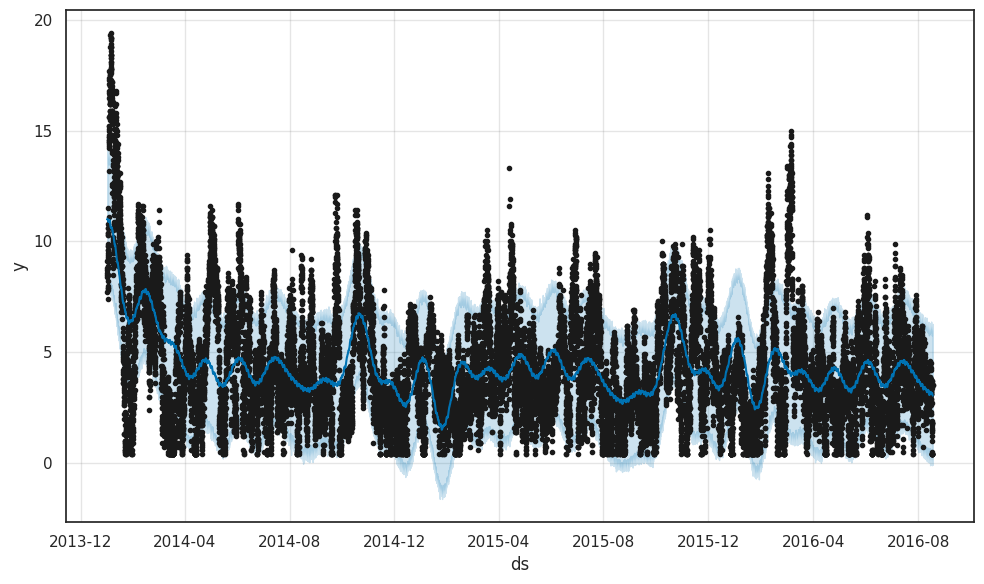

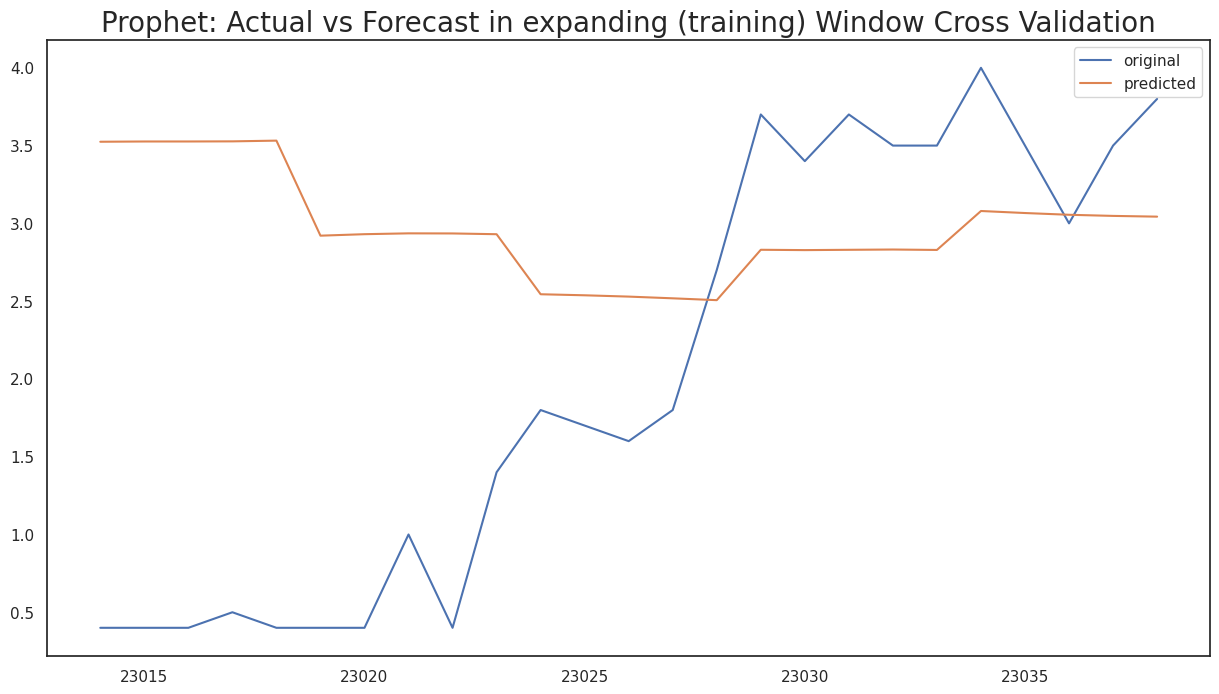

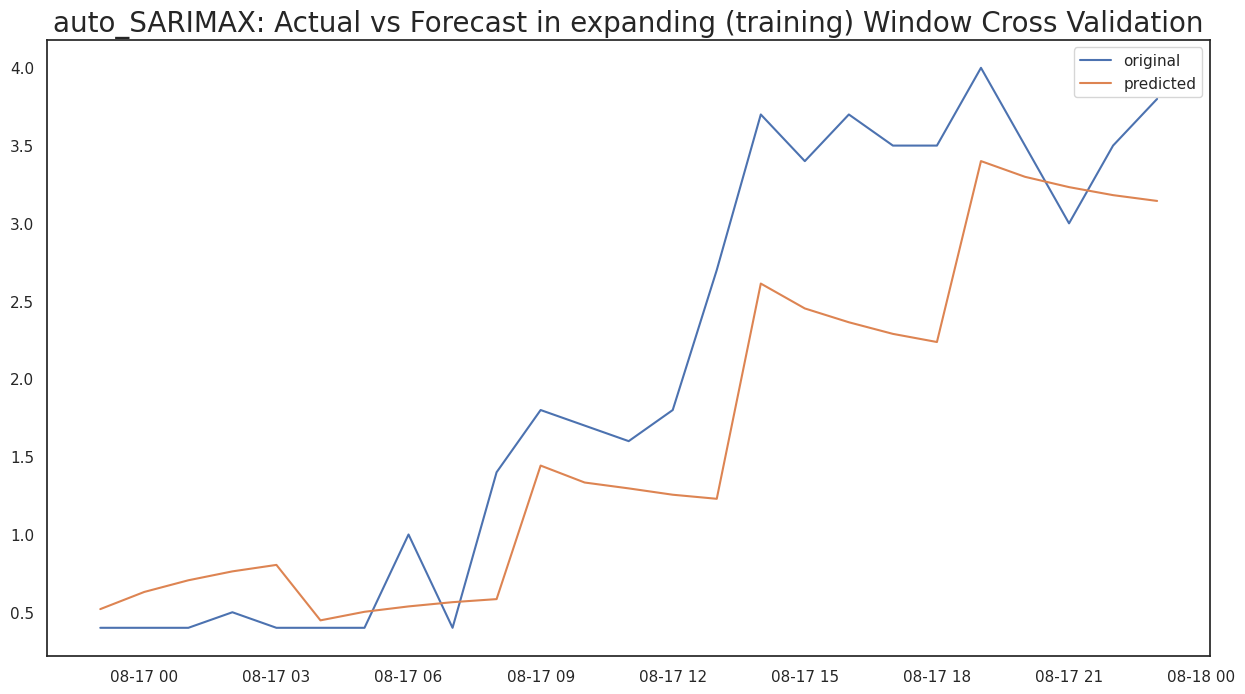

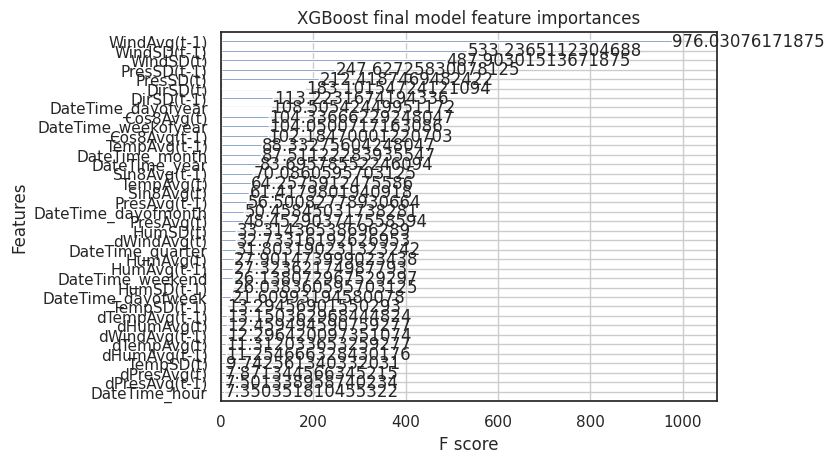

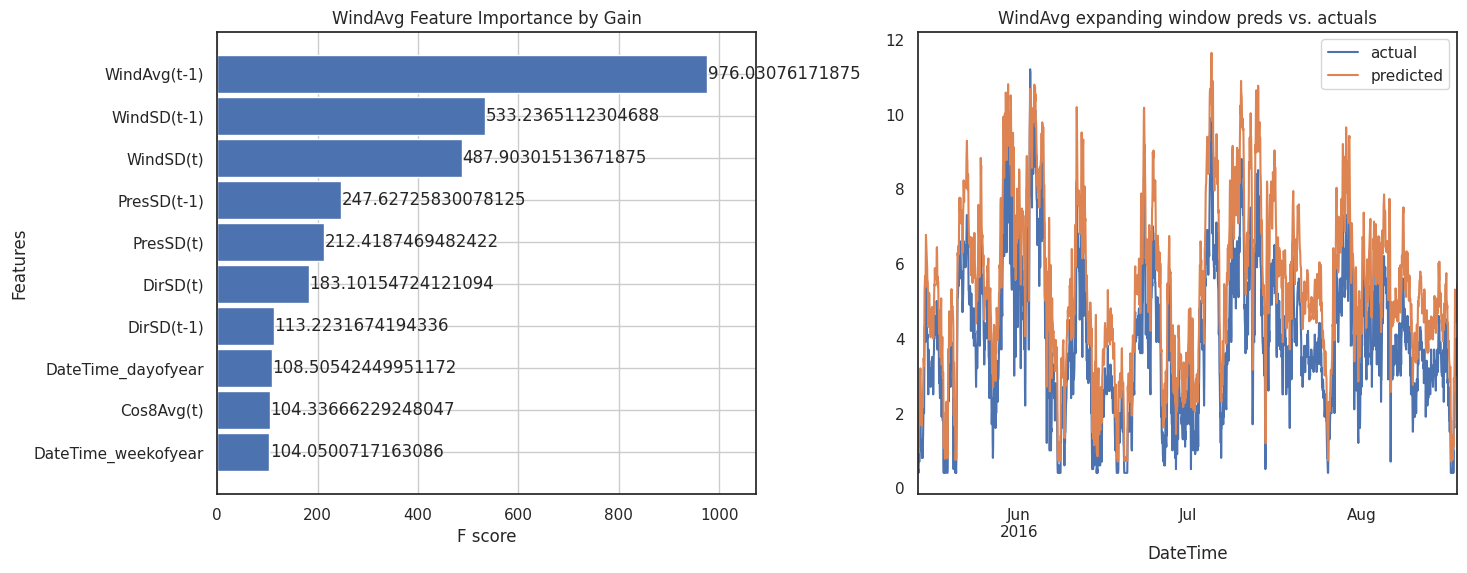

In [ ]:
model = auto_timeseries(score_type='rmse',   # функция потерь
                        time_interval='H',   # дневной интервал
                        model_type='best',   # сохраняем лучшую модель
                        verbose=1)
#в качестве проверочной выборки берем последние 144 точки, т.е.  последние сутки набора данных
train, val = data.iloc[1:23040], data.iloc[23040:]
model.fit(traindata=train,      # на выборке train
          ts_column='DateTime',   # колонка с временными отсчетами
          target='WindAvg')

In [ ]:
model.get_leaderboard()

name      rmse
1  auto_SARIMAX  0.616011
0       Prophet  1.485863
2            ML  1.600167

In [ ]:
#функции для отображения корреляции
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1]

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['WindMain'],
              title=''): # список имен каналов данных
  y_len = y_true.shape[0]
  steps = range(0, back_steps_max + 1)
  plt.figure(figsize=(14, 7))
  cross_corr = [correlate(y_true[:y_len - step], y_pred[step:]) for step in steps]
  auto_corr = [correlate(y_true[:y_len - step], y_true[step:]) for step in steps]
  plt.plot(cross_corr, label=f'Прогноз')
  plt.plot(auto_corr, label=f'Эталон')
#смещаю в цикл
  plt.title(f'{title} {chn_names[0]}')
  plt.xticks(steps)
  plt.xlabel('Шаги смещения')
  plt.ylabel('Коэффициент корреляции')
  plt.legend()
  plt.show()

Наиболее близкий график у модели ML

Predicting using test dataframe shape = (144, 16) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for DateTime. Provide strf_time format during "setup" for better results.
ML predictions completed


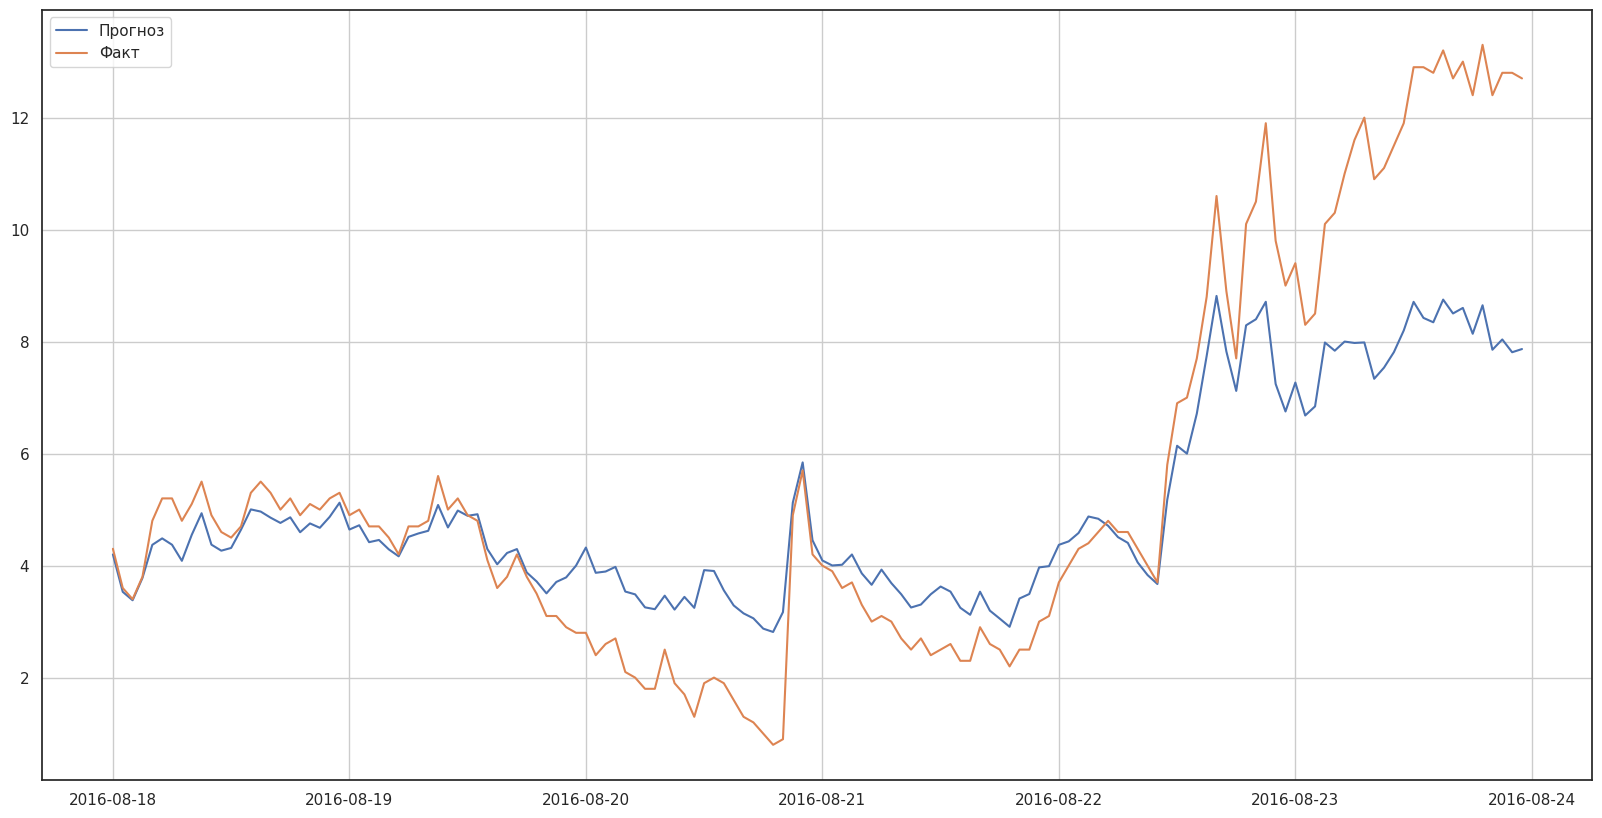

In [ ]:
pred = model.predict(val, model='ML')['yhat'].to_numpy(float)
plt.figure(figsize=(20, 10))
plt.plot(val['DateTime'], pred, label='Прогноз')
plt.plot(val['DateTime'], val['WindAvg'], label='Факт')
plt.legend()
plt.grid()
plt.show()

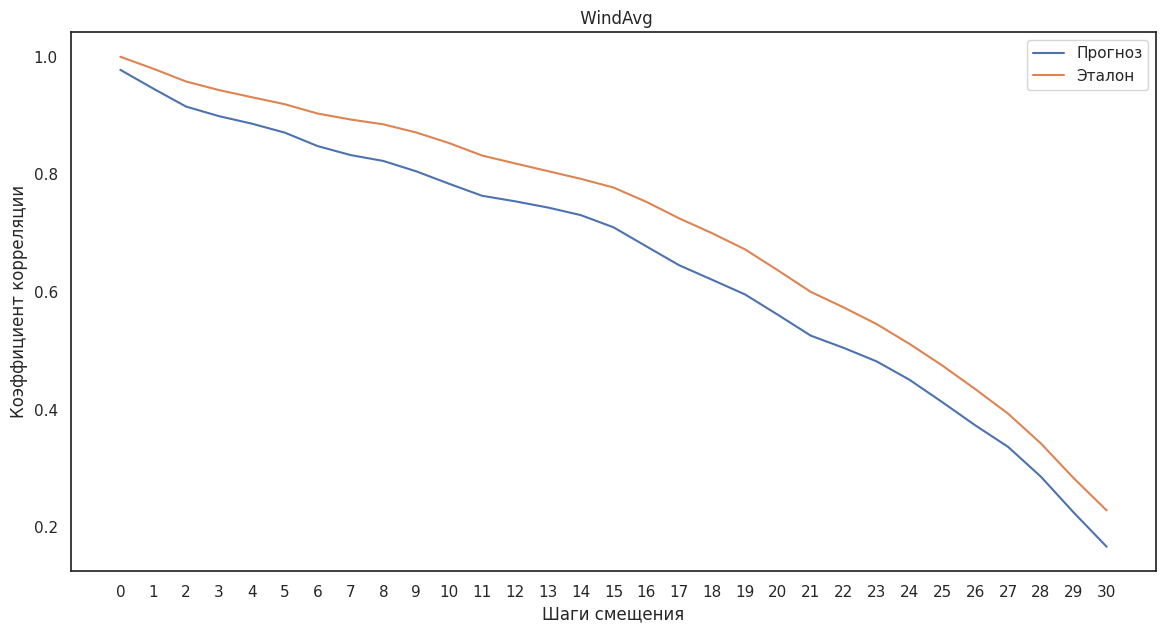

In [ ]:
show_corr(pred, val['WindAvg'], # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['WindAvg'],
              title='')

###Эксперимент 2

Во втором эксперименты увеличим размер проверочной выборки до 2 дней

Start of Fit.....
    Target variable given as = WindAvg
Start of loading of data.....
    Inputs: ts_column = DateTime, sep = ,, target = ['WindAvg']
    Using given input: pandas dataframe...
    DateTime column exists in given train data...
    train data shape = (22895, 15)
Alert: Could not detect strf_time_format of DateTime. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


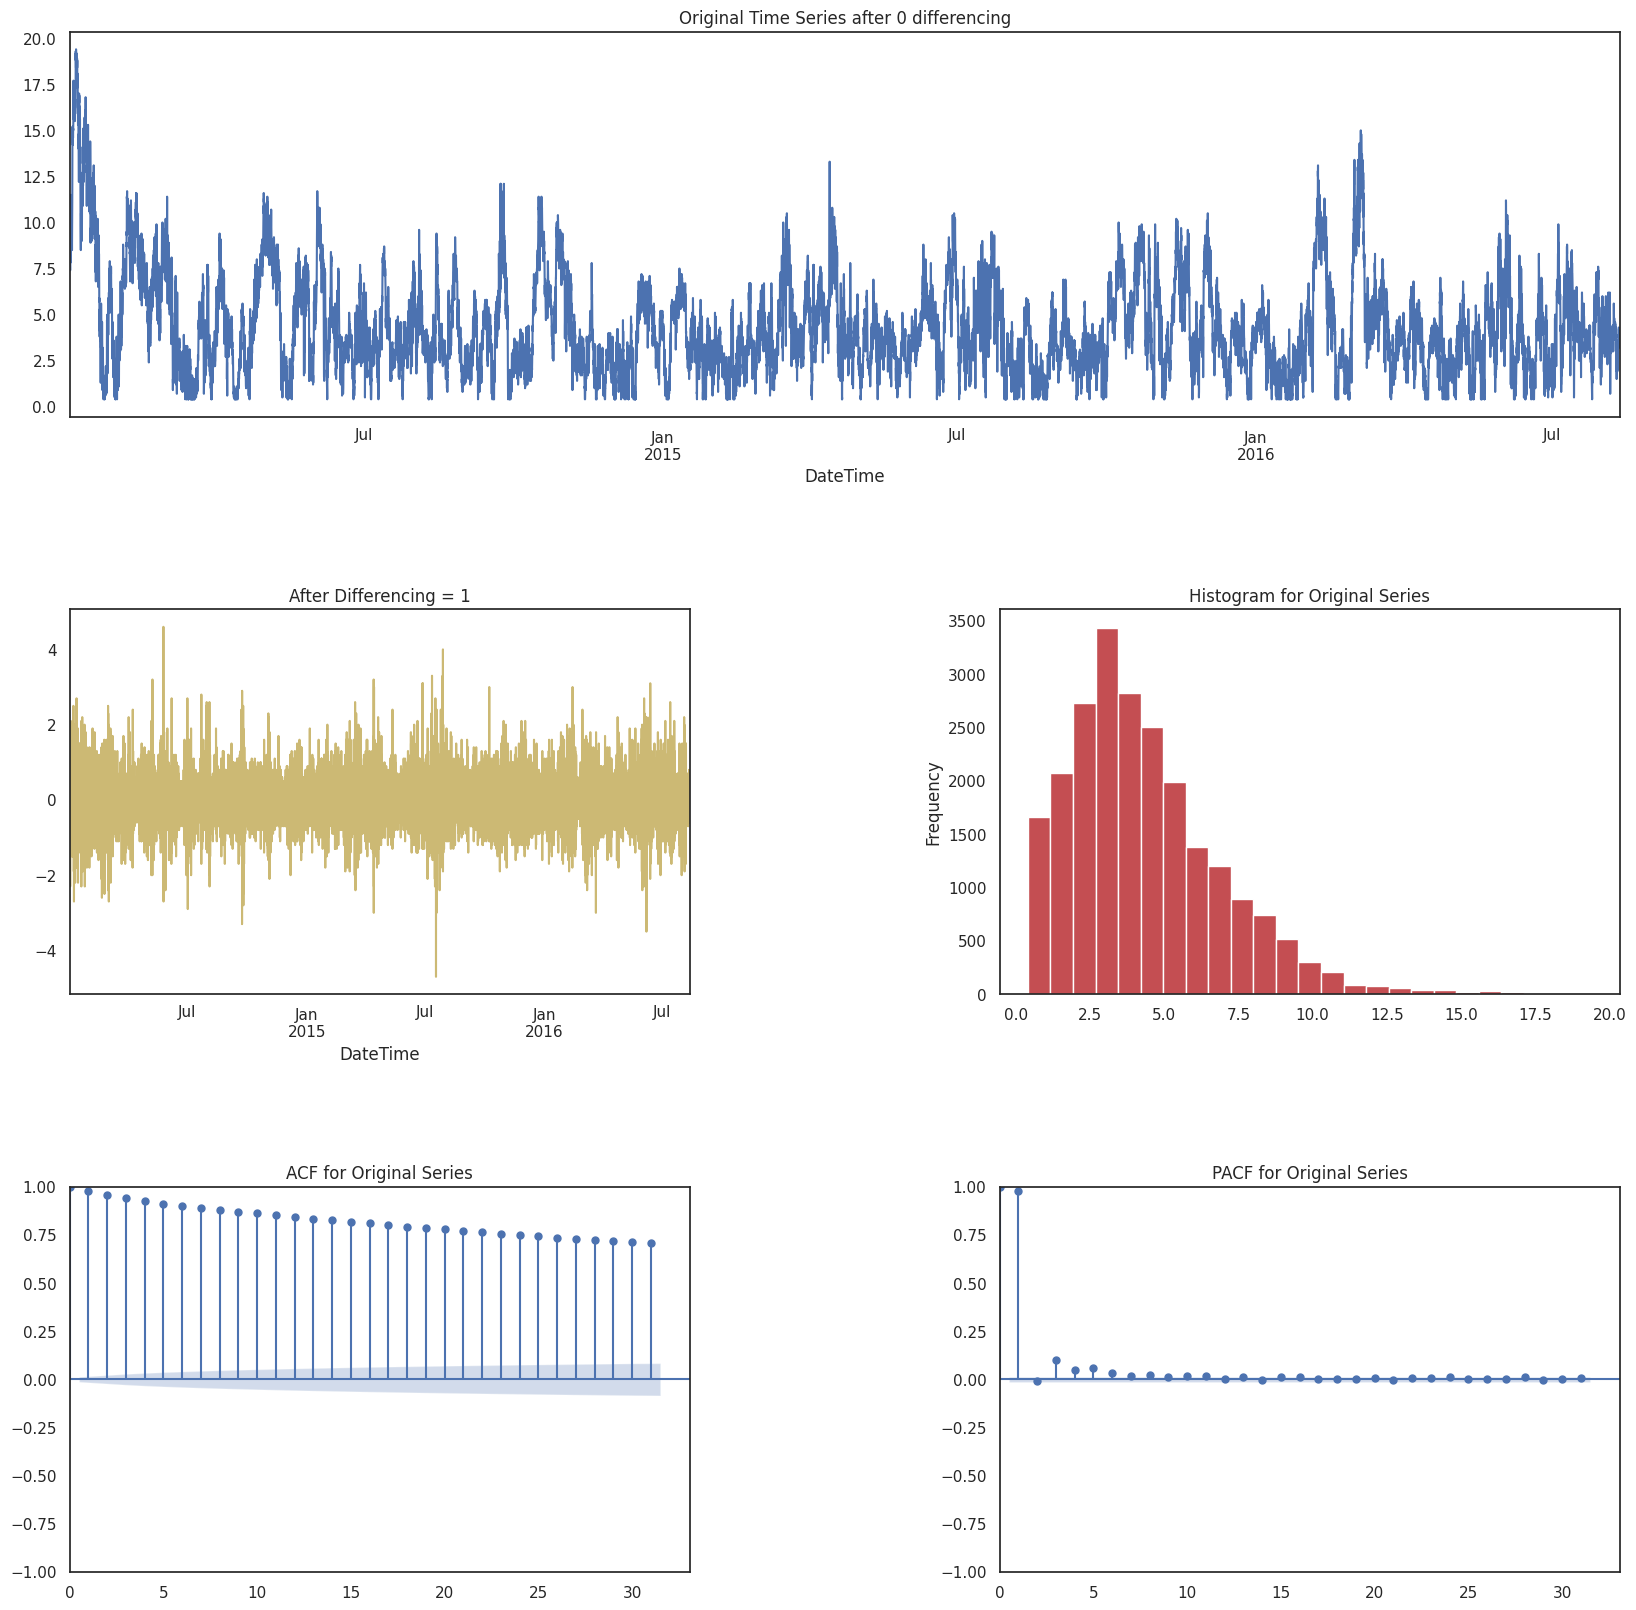

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/fs2ef03o.json


Time Interval is given as H
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(22895, 16)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 22870 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/eafuhe6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51245', 'data', 'file=/tmp/tmpsgg85bzq/fs2ef03o.json', 'init=/tmp/tmpsgg85bzq/eafuhe6b.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelvj650qw_/prophet_model-20240603074756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
07:47:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/60k3cbi_.json


    RMSE = 0.20
    Std Deviation of actuals = 0.17
    Normalized RMSE (as pct of std dev) = 117%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 22875 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/qyxxscln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97098', 'data', 'file=/tmp/tmpsgg85bzq/60k3cbi_.json', 'init=/tmp/tmpsgg85bzq/qyxxscln.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelhmr6tm7p/prophet_model-20240603074806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
07:48:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/feg357lu.json


    RMSE = 0.67
    Std Deviation of actuals = 0.14
    Normalized RMSE (as pct of std dev) = 493%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 22880 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/6xmag5hy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32733', 'data', 'file=/tmp/tmpsgg85bzq/feg357lu.json', 'init=/tmp/tmpsgg85bzq/6xmag5hy.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelqt3dlr8w/prophet_model-20240603074813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
07:48:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/piswcbfb.json


    RMSE = 0.97
    Std Deviation of actuals = 0.22
    Normalized RMSE (as pct of std dev) = 433%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 22885 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/5myy3gvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16762', 'data', 'file=/tmp/tmpsgg85bzq/piswcbfb.json', 'init=/tmp/tmpsgg85bzq/5myy3gvp.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_models112pr8j/prophet_model-20240603074822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
07:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.47
    Std Deviation of actuals = 0.22
    Normalized RMSE (as pct of std dev) = 218%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 22890 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/g1p9e5tp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/kh_udxin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33431', 'data', 'file=/tmp/tmpsgg85bzq/g1p9e5tp.json', 'init=/tmp/tmpsgg85bzq/kh_udxin.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_model3x6dmob2/prophet_model-20240603074830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
07:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.36
    Std Deviation of actuals = 0.17
    Normalized RMSE (as pct of std dev) = 208%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 0.50
    MSE (Mean Squared Error = 0.35
    MAPE (Mean Absolute Percent Error) = 13%
    RMSE (Root Mean Squared Error) = 0.5952
    Normalized RMSE (MinMax) = 54%
    Normalized RMSE (as Std Dev of Actuals)= 191%
Time Taken = 43 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/x_3c0ect.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/hghmyhwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96971', 'data', 'file=/tmp/tmpsgg85bzq/x_3c0ect.json', 'init=/tmp/tmpsgg85bzq/hghmyhwv.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelhznpq4ae/prophet_model-20240603074839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
07:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 22870 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 37099.401
Static Forecasts:
    RMSE = 0.98
    Std Deviation of Actuals = 0.17
    Normalized RMSE (as pct of std dev) = 567.2%

Fold Number: 2 --> Train Shape: 22875 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 37105.823
Static Forecasts:
    RMSE = 0.32
    Std Deviation of Actuals = 0.14
    Normalized RMSE (as pct of std dev) = 236.7%

Fold Number: 3 --> Train Shape: 22880 Test Shape: 5

    Finding 

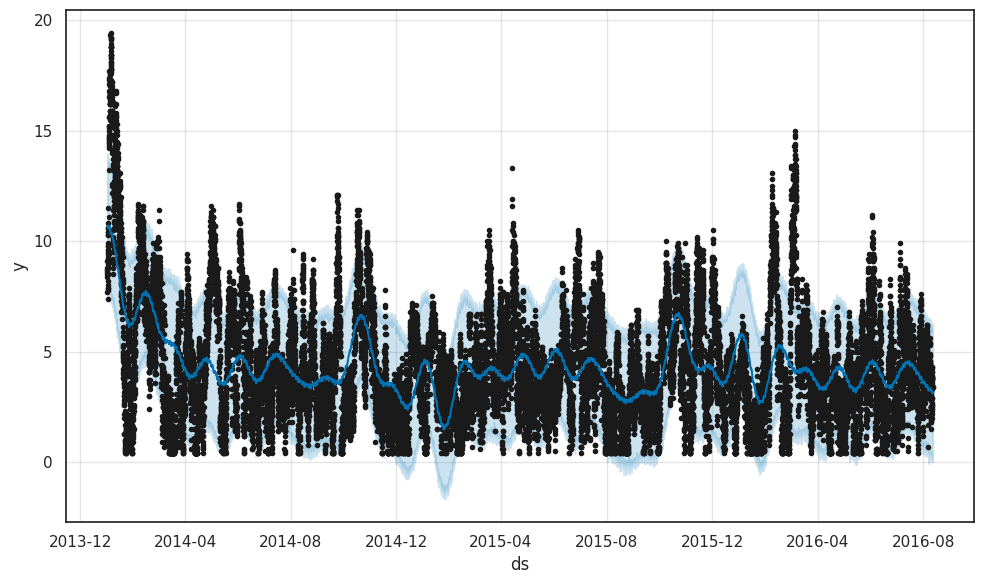

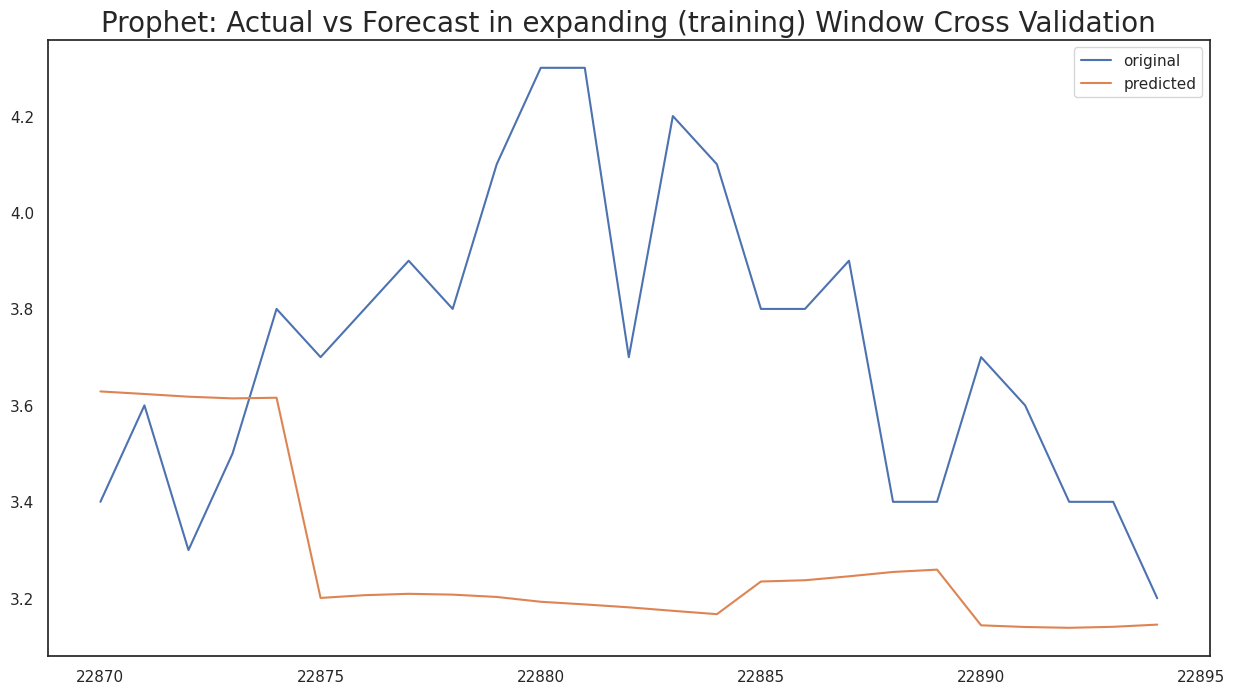

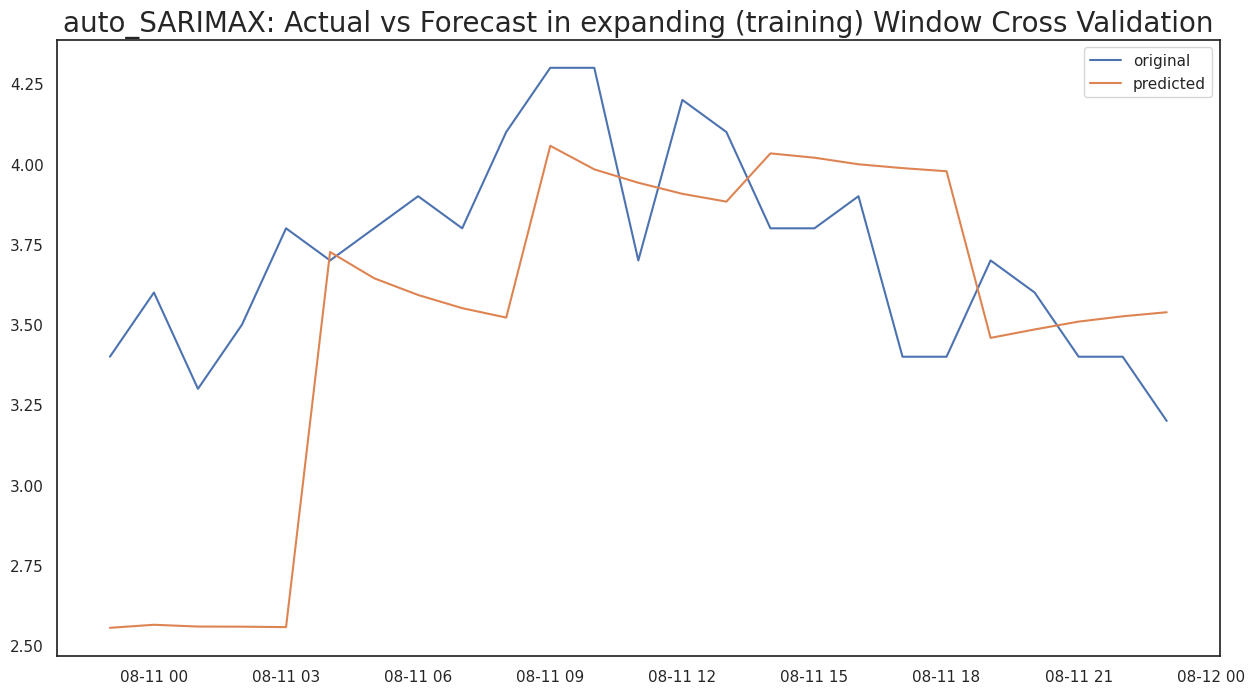

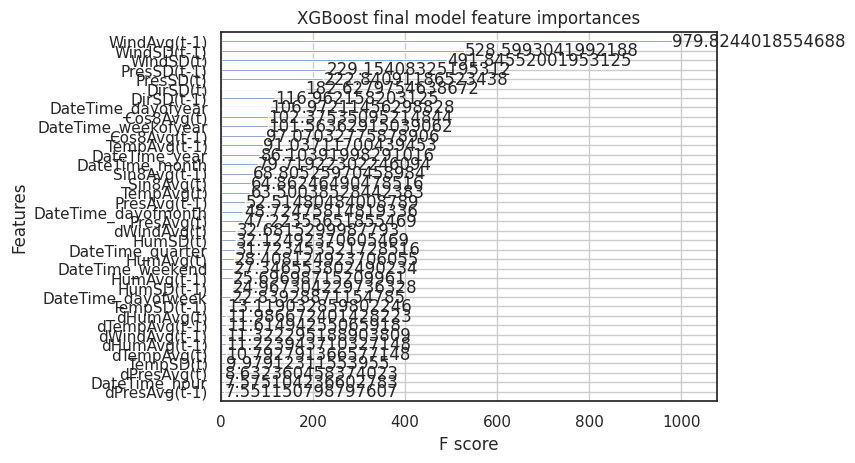

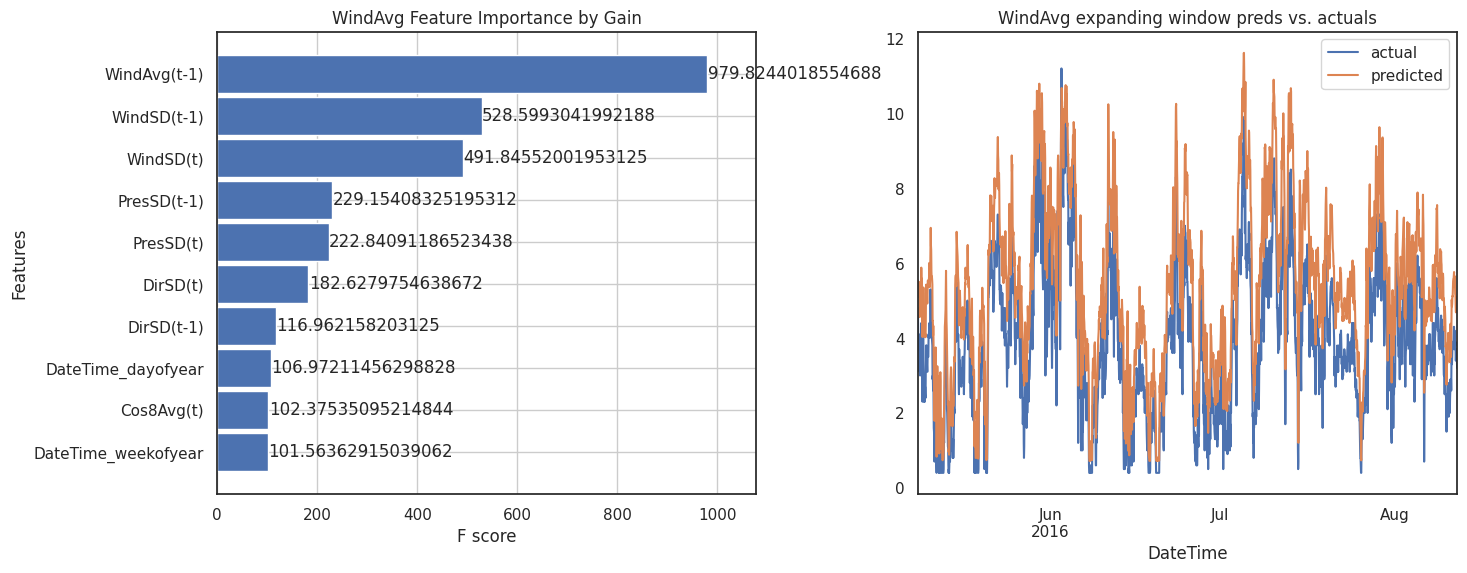

In [ ]:
model2 = auto_timeseries(score_type='rmse',   # функция потерь
                        time_interval='H',   # дневной интервал
                        model_type='best',   # сохраняем лучшую модель
                        verbose=1)
train2, val2 = data.iloc[1:22896], data.iloc[22896:]
model2.fit(traindata=train2,      # на выборке train
          ts_column='DateTime',   # колонка с временными отсчетами
          target='WindAvg')

In [ ]:
model2.get_leaderboard()

name      rmse
1  auto_SARIMAX  0.433271
0       Prophet  0.533458
2            ML  1.621755

Predicting using test dataframe shape = (288, 16) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for DateTime. Provide strf_time format during "setup" for better results.
ML predictions completed


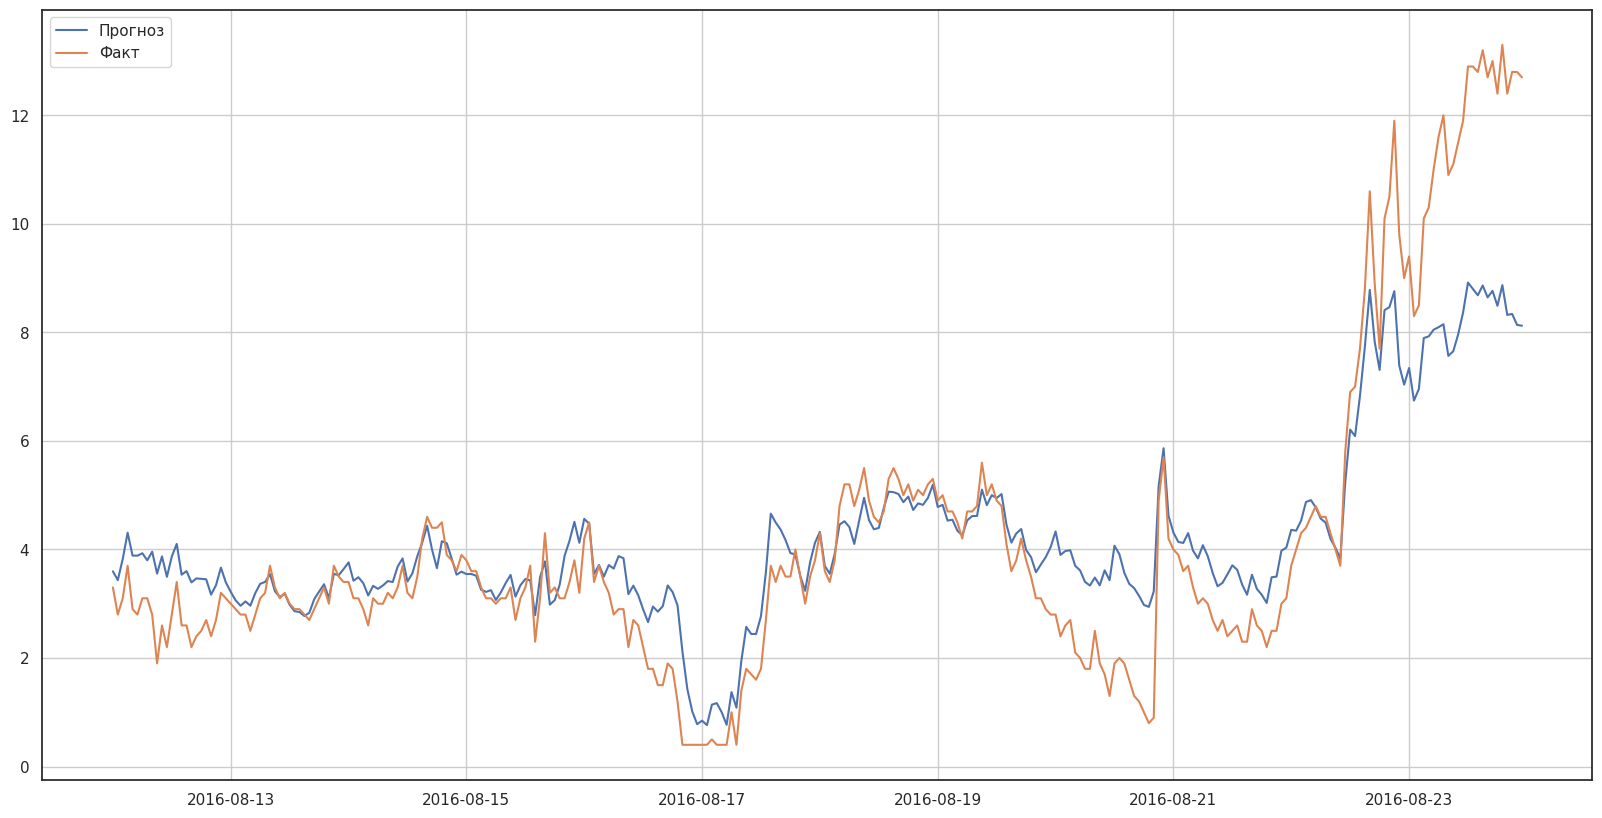

In [ ]:
pred2 = model2.predict(val2, model='ML')['yhat'].to_numpy(float)
plt.figure(figsize=(20, 10))
plt.plot(val2['DateTime'], pred2, label='Прогноз')
plt.plot(val2['DateTime'], val2['WindAvg'], label='Факт')
plt.legend()
plt.grid()
plt.show()

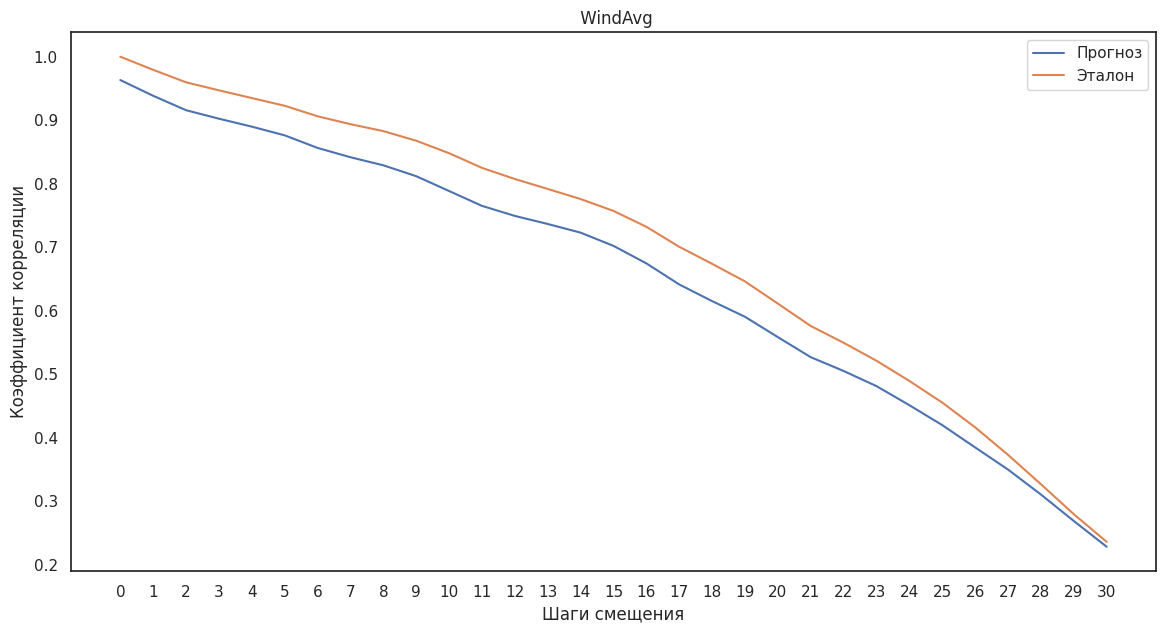

In [ ]:
show_corr(pred2, val2['WindAvg'], # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['WindAvg'],
              title='')

###Эксперимент 3

В третьем эксперименте отбросим давление и влажность, которые не измеряются на других вышках

In [ ]:
data3 = data[['DateTime','WindAvg','dWindAvg','WindSD','Sin8Avg','Cos8Avg','DirSD','TempAvg','dTempAvg','TempSD']].copy(deep=True).reset_index()
del data3['index']

In [ ]:
data3

DateTime  WindAvg  dWindAvg  WindSD   Sin8Avg   Cos8Avg  \
0     2014-01-01 00:00:00      9.0       0.0     0.8  0.559193  0.829038   
1     2014-01-01 01:00:00      9.1       0.1     0.8  0.573576  0.819152   
2     2014-01-01 02:00:00      8.7      -0.4     1.0  0.529919  0.848048   
3     2014-01-01 03:00:00      8.8       0.1     0.9  0.515038  0.857167   
4     2014-01-01 04:00:00      8.6      -0.2     1.1  0.559193  0.829038   
...                   ...      ...       ...     ...       ...       ...   
23179 2016-08-23 19:00:00     13.3       0.9     1.6  0.422618  0.906308   
23180 2016-08-23 20:00:00     12.4      -0.9     1.7  0.453990  0.891007   
23181 2016-08-23 21:00:00     12.8       0.4     1.8  0.469472  0.882948   
23182 2016-08-23 22:00:00     12.8       0.0     2.0  0.469472  0.882948   
23183 2016-08-23 23:00:00     12.7      -0.1     2.0  0.484810  0.874620   

          DirSD  TempAvg  dTempAvg  TempSD  
0      0.087156     -7.9       0.0     0.1  
1      0.087156     -7.9       0.0     0.1  
2      0.087156     -7.9       0.0     0.1  
3      0.104528     -7.9       0.0     0.1  
4      0.104528     -7.8       0.1     0.1  
...         ...      ...       ...     ...  
23179  0.139173      2.9       0.0     0.0  
23180  0.139173      2.9       0.0     0.1  
23181  0.190809      2.8      -0.1     0.0  
23182  0.139173      2.8       0.0     0.0  
23183  0.156434      2.8       0.0     0.1  

[23184 rows x 10 columns]

Start of Fit.....
    Target variable given as = WindAvg
Start of loading of data.....
    Inputs: ts_column = DateTime, sep = ,, target = ['WindAvg']
    Using given input: pandas dataframe...
    DateTime column exists in given train data...
    train data shape = (23039, 9)
Alert: Could not detect strf_time_format of DateTime. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


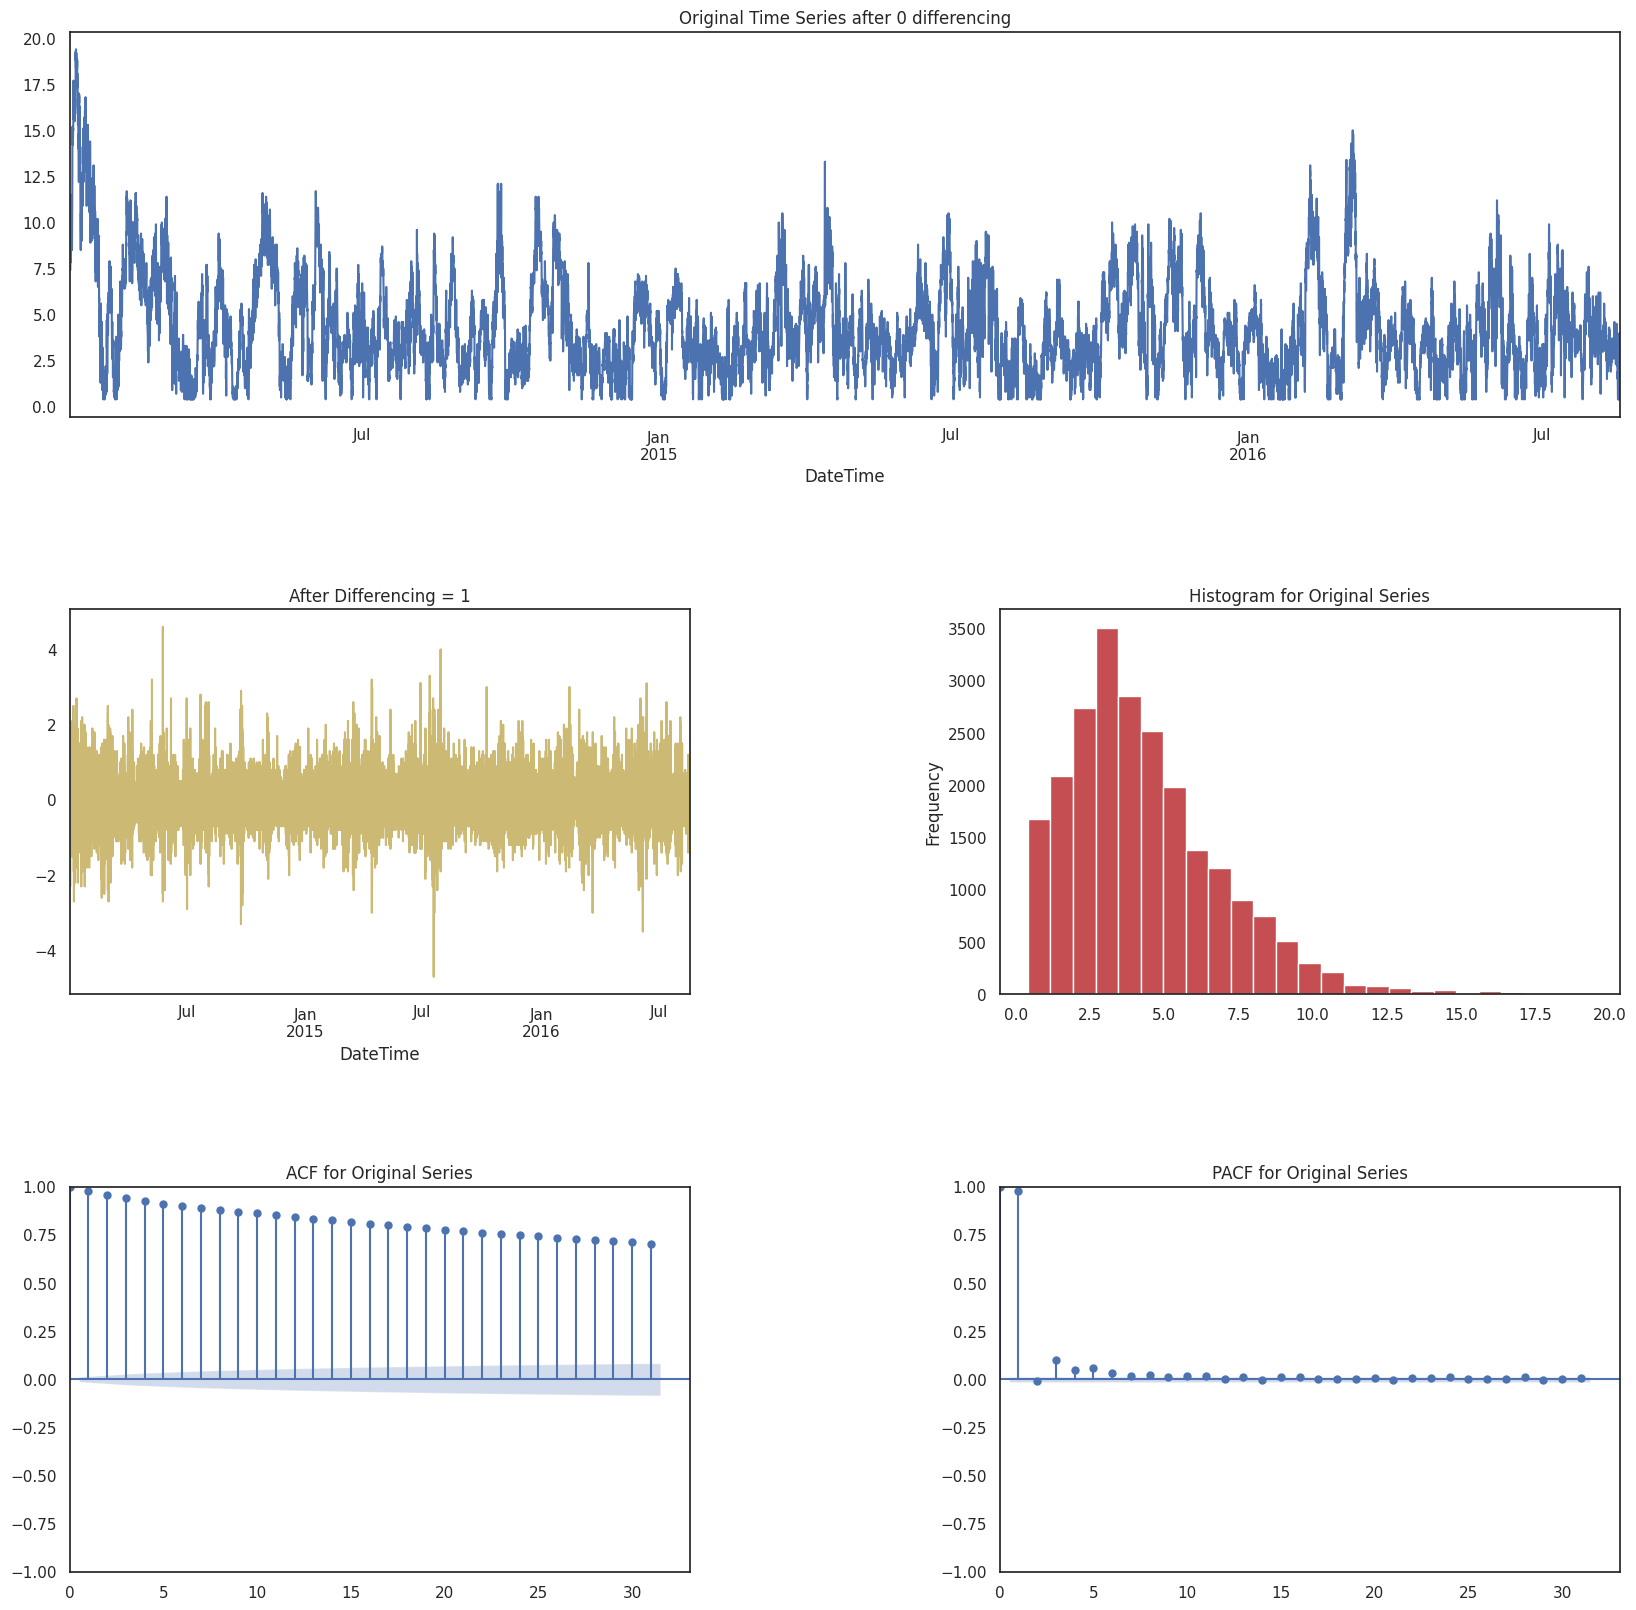

Time Interval is given as H
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(23039, 10)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 23014 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/x7tbz_0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/037doyv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36916', 'data', 'file=/tmp/tmpsgg85bzq/x7tbz_0x.json', 'init=/tmp/tmpsgg85bzq/037doyv4.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_model0_kv6l5t/prophet_model-20240603084223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:42:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/a3lyodji.json


    RMSE = 3.11
    Std Deviation of actuals = 0.04
    Normalized RMSE (as pct of std dev) = 7769%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 23019 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/5y1zdmn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7651', 'data', 'file=/tmp/tmpsgg85bzq/a3lyodji.json', 'init=/tmp/tmpsgg85bzq/5y1zdmn9.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelvowlrhop/prophet_model-20240603084233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/nl5fjxjh.json


    RMSE = 2.25
    Std Deviation of actuals = 0.41
    Normalized RMSE (as pct of std dev) = 546%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 23024 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/upul52nn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23379', 'data', 'file=/tmp/tmpsgg85bzq/nl5fjxjh.json', 'init=/tmp/tmpsgg85bzq/upul52nn.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelkun54afp/prophet_model-20240603084241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.73
    Std Deviation of actuals = 0.40
    Normalized RMSE (as pct of std dev) = 184%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 23029 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/u8lpe9ys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/h3t7f3kn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33668', 'data', 'file=/tmp/tmpsgg85bzq/u8lpe9ys.json', 'init=/tmp/tmpsgg85bzq/h3t7f3kn.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modeli2i1fdzs/prophet_model-20240603084250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/y888ou64.json


    RMSE = 0.74
    Std Deviation of actuals = 0.12
    Normalized RMSE (as pct of std dev) = 617%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 23034 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/2qbcp681.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2758', 'data', 'file=/tmp/tmpsgg85bzq/y888ou64.json', 'init=/tmp/tmpsgg85bzq/2qbcp681.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modele9h3nqsz/prophet_model-20240603084258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 0.60
    Std Deviation of actuals = 0.34
    Normalized RMSE (as pct of std dev) = 178%
Cross Validation window: 5 completed


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/eirceuif.json



-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 1.45
    MSE (Mean Squared Error = 3.23
    MAPE (Mean Absolute Percent Error) = 252%
    RMSE (Root Mean Squared Error) = 1.7976
    Normalized RMSE (MinMax) = 50%
    Normalized RMSE (as Std Dev of Actuals)= 128%
Time Taken = 44 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/9q_4fp9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7200', 'data', 'file=/tmp/tmpsgg85bzq/eirceuif.json', 'init=/tmp/tmpsgg85bzq/9q_4fp9c.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelzboo9qw6/prophet_model-20240603084307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
08:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 23014 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 37265.252
Static Forecasts:
    RMSE = 0.28
    Std Deviation of Actuals = 0.04
    Normalized RMSE (as pct of std dev) = 701.4%

Fold Number: 2 --> Train Shape: 23019 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 37268.561
Static Forecasts:
    RMSE = 0.43
    Std Deviation of Actuals = 0.41
    Normalized RMSE (as pct of std dev) = 104.1%

Fold Number: 3 --> Train Shape: 23024 Test Shape: 5

    Finding 

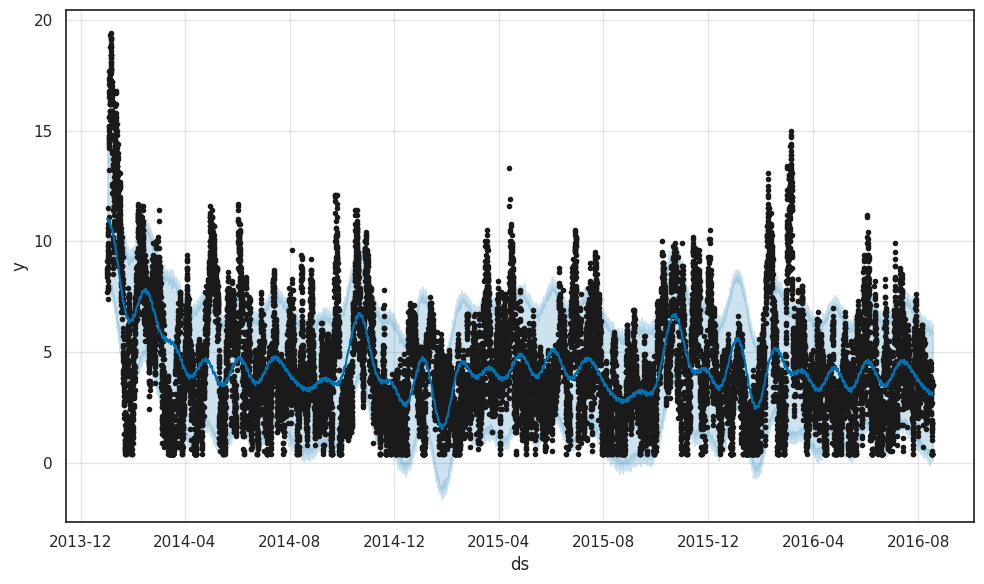

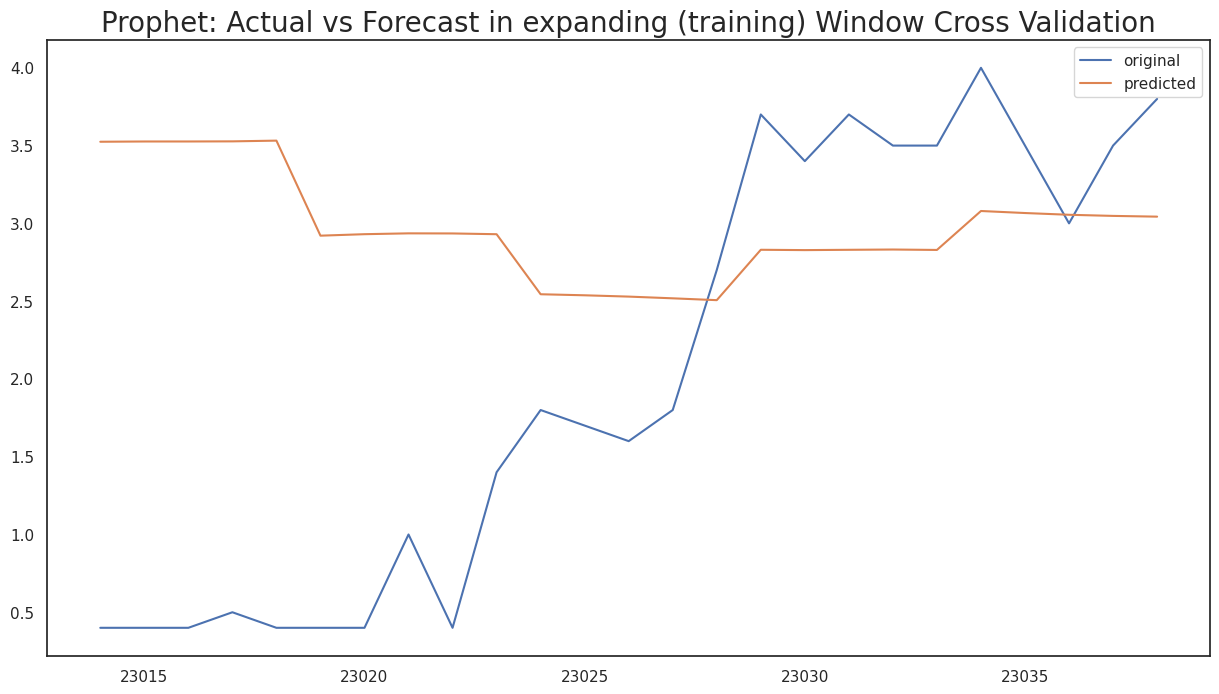

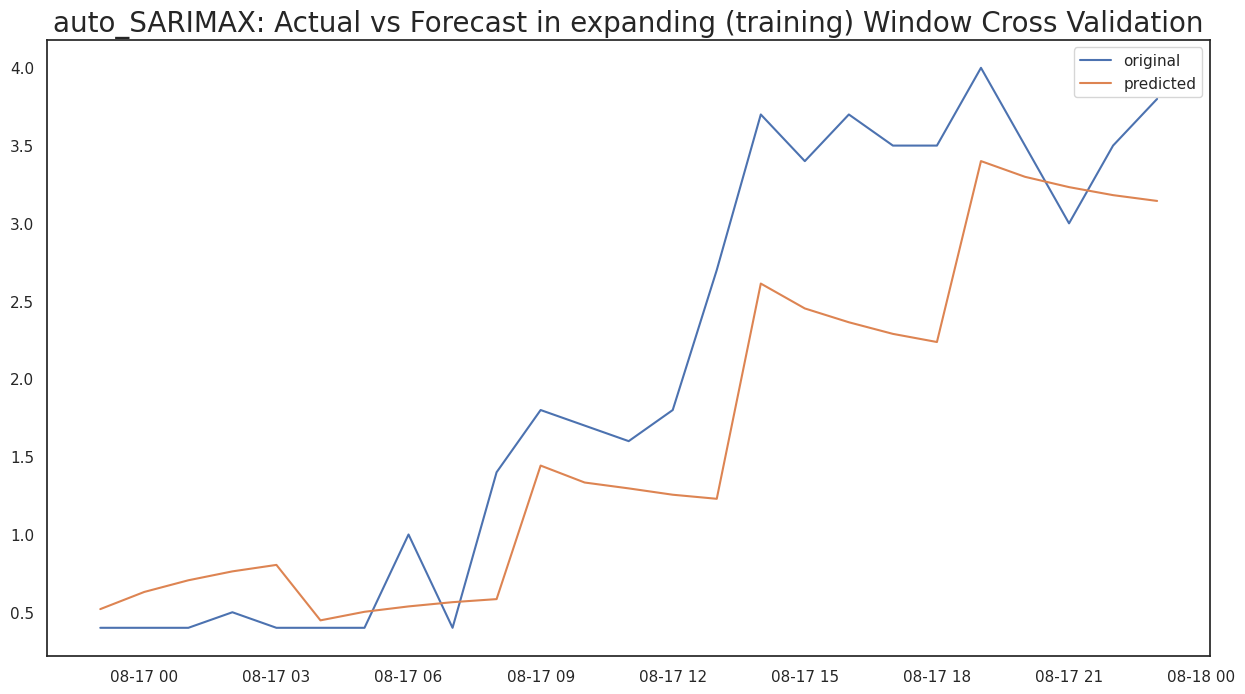

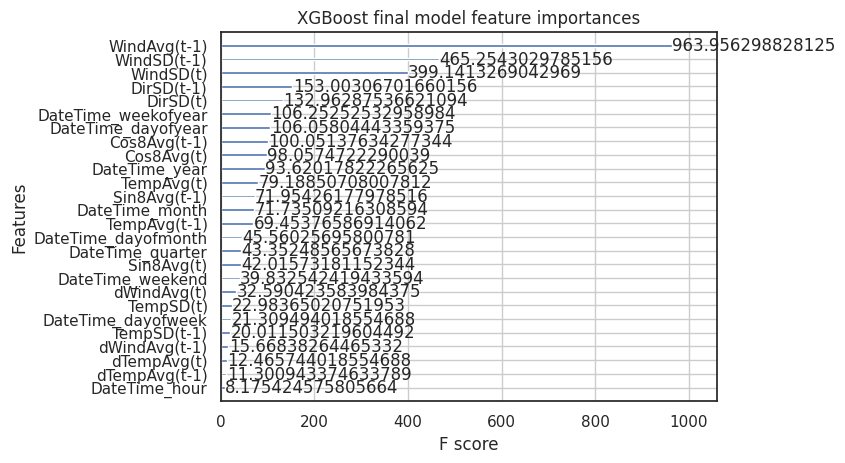

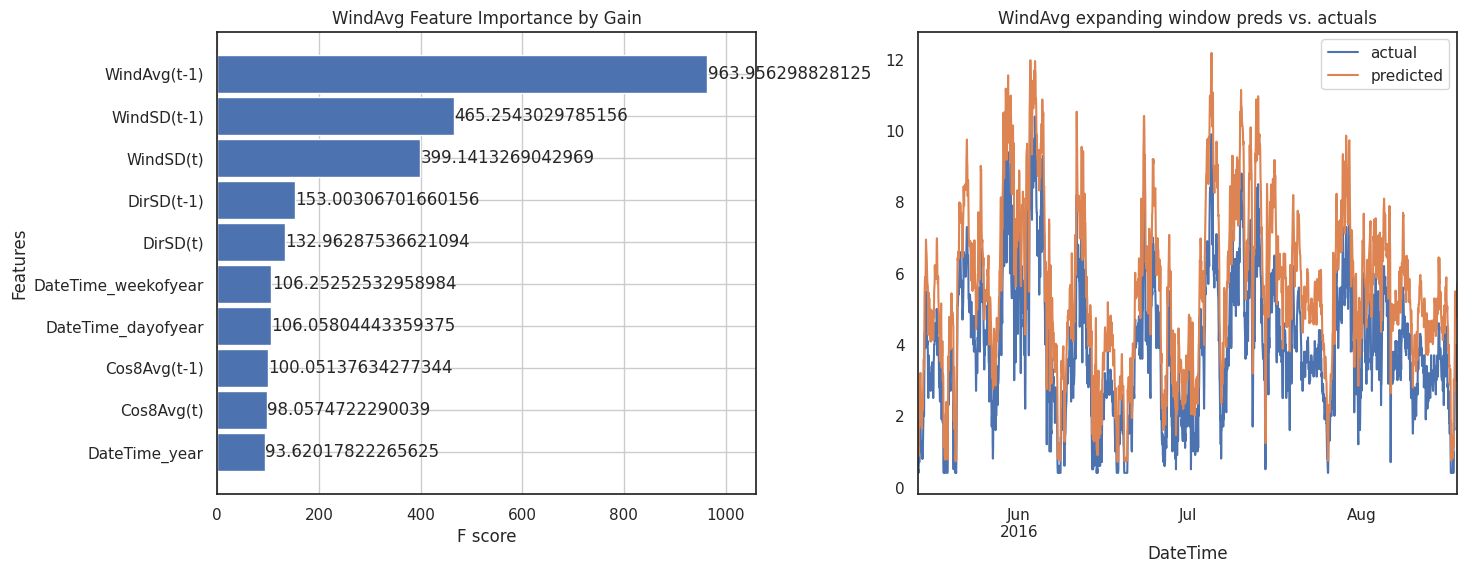

In [ ]:
model3 = auto_timeseries(score_type='rmse',   # функция потерь
                        time_interval='H',   # дневной интервал
                        model_type='best',   # сохраняем лучшую модель
                        verbose=1)
train3, val3 = data3.iloc[1:23040], data3.iloc[23040:]
model3.fit(traindata=train3,      # на выборке train
          ts_column='DateTime',   # колонка с временными отсчетами
          target='WindAvg')

In [ ]:
model3.get_leaderboard()

name      rmse
1  auto_SARIMAX  0.616011
0       Prophet  1.485863
2            ML  1.776115

Predicting using test dataframe shape = (144, 10) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for DateTime. Provide strf_time format during "setup" for better results.
ML predictions completed


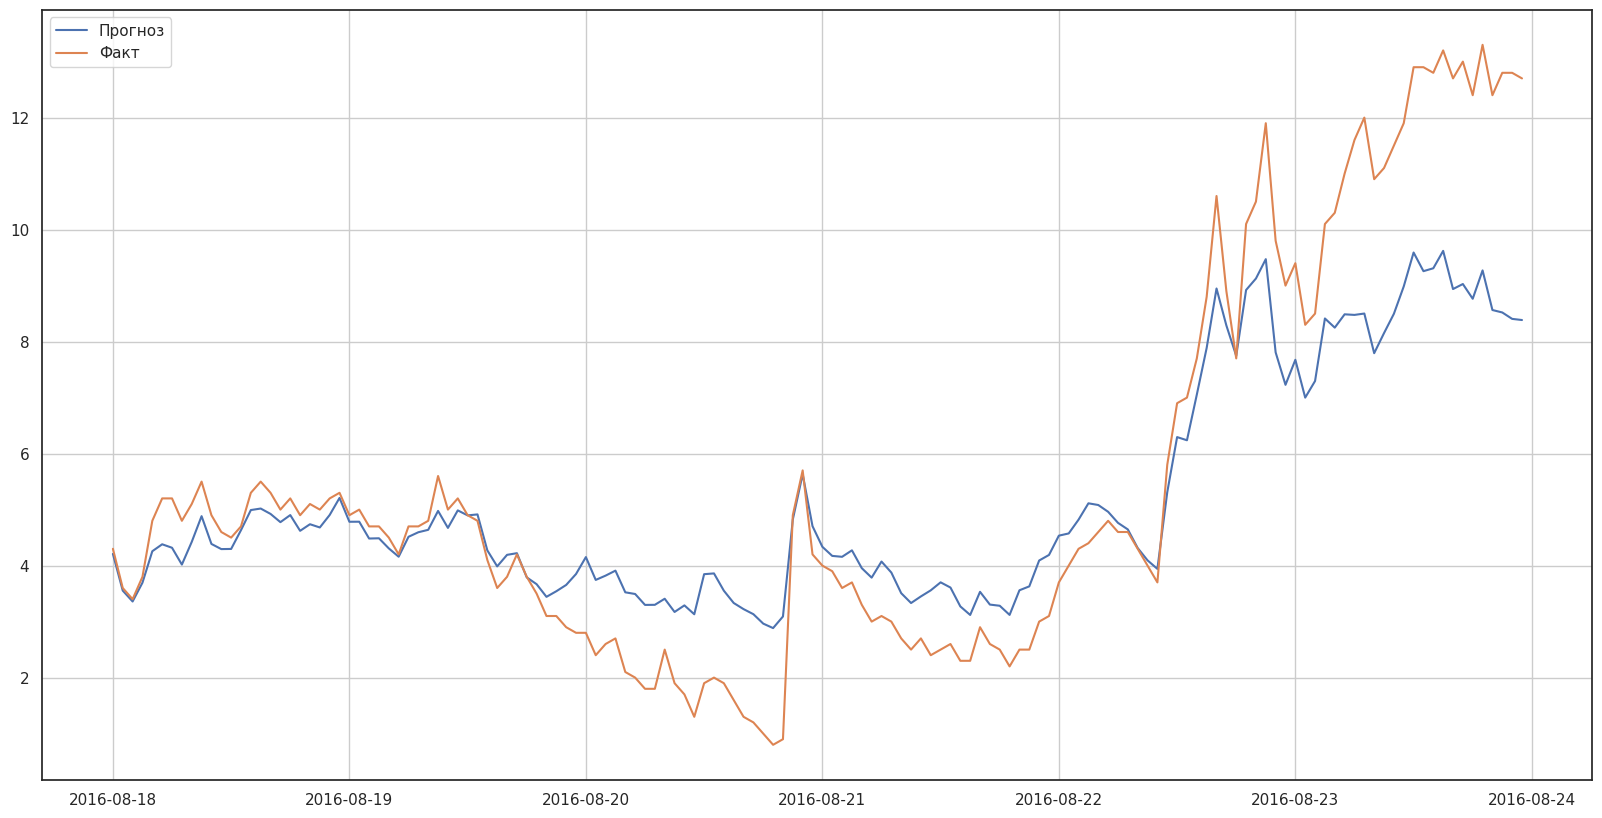

In [ ]:
pred3 = model3.predict(val3, model='ML')['yhat'].to_numpy(float)
plt.figure(figsize=(20, 10))
plt.plot(val3['DateTime'], pred3, label='Прогноз')
plt.plot(val3['DateTime'], val3['WindAvg'], label='Факт')
plt.legend()
plt.grid()
plt.show()

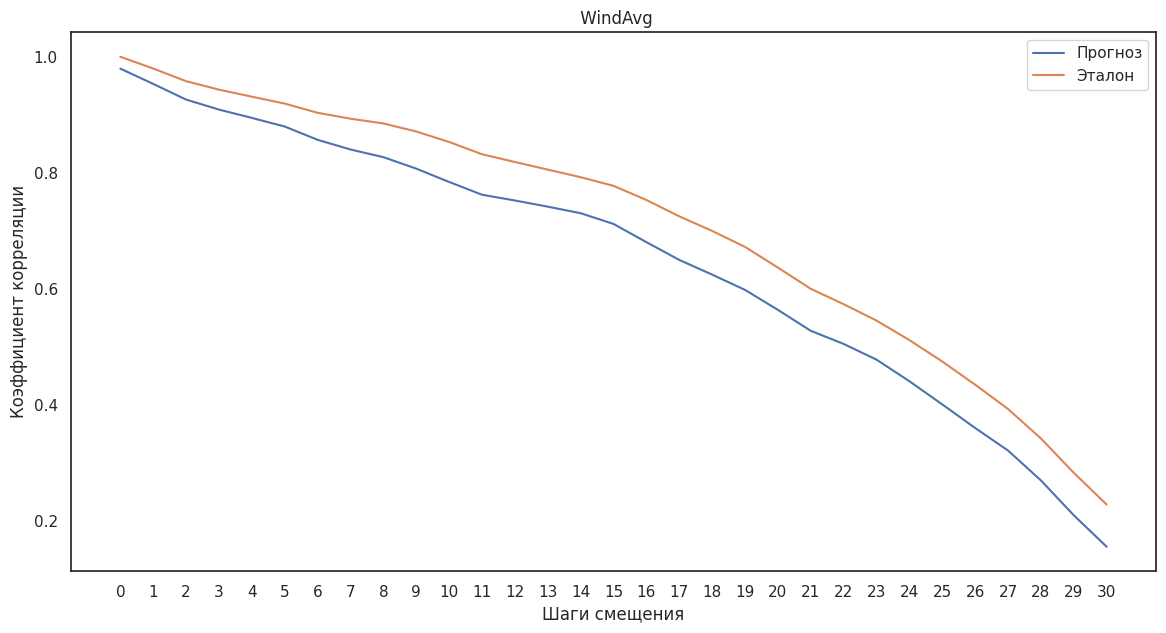

In [ ]:
show_corr(pred3, val3['WindAvg'], # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['WindAvg'],
              title='')

###Эксперимент 4

Для проверки в четвертом эксперименте возьмем данные для вышки Палана,  диапазон непрерывных и корректных данных

In [ ]:
data4 = base0[sites[2]].loc[(base0[sites[2]]['Date'] >= np.datetime64('2010-12-05'))&(base0[sites[2]]['Date'] <= np.datetime64('2013-08-13'))][['DateTime','CH5Avg','dCH5Avg','CH5SD','Sin8Avg','Cos8Avg','Sin8SD','CH9Avg','dCH9Avg','CH9SD']].copy(deep=True).reset_index()
data4 = data4.rename(columns={'CH5Avg':'WindAvg','dCH5Avg':'dWindAvg','CH5SD':'WindSD','CH8Avg':'DirAvg','Sin8SD':'DirSD','CH9Avg':'TempAvg','dCH9Avg':'dTempAvg','CH9SD':'TempSD'})
del data4['index']

In [ ]:
data4

DateTime  WindAvg  dWindAvg  WindSD   Sin8Avg   Cos8Avg  \
0      2010-12-05 00:00:00      2.1      -0.6     1.2  0.951057 -0.309017   
1      2010-12-05 00:10:00      2.6       0.5     1.3  0.069756 -0.997564   
2      2010-12-05 00:20:00      2.1      -0.5     0.9 -0.438371  0.898794   
3      2010-12-05 00:30:00      3.1       1.0     1.3 -0.190809  0.981627   
4      2010-12-05 00:40:00      3.3       0.2     1.0 -0.104528  0.994522   
...                    ...      ...       ...     ...       ...       ...   
141403 2013-08-13 23:10:00      0.7       0.0     0.4 -0.681998  0.731354   
141404 2013-08-13 23:20:00      0.6      -0.1     0.3 -0.998630  0.052336   
141405 2013-08-13 23:30:00      0.4      -0.2     0.1 -0.052336  0.998630   
141406 2013-08-13 23:40:00      0.4       0.0     0.0  0.087156  0.996195   
141407 2013-08-13 23:50:00      0.6       0.2     0.4  0.017452  0.999848   

           DirSD  TempAvg  dTempAvg  TempSD  
0       0.990268      0.6       0.7     0.4  
1       0.874620      0.9       0.3     0.3  
2       0.681998      0.5      -0.4     0.1  
3       0.292372      0.4      -0.1     0.1  
4       0.374607      0.5       0.1     0.1  
...          ...      ...       ...     ...  
141403  0.997564      5.6      -0.3     0.2  
141404  0.681998      5.6       0.0     0.1  
141405  0.390731      5.7       0.1     0.1  
141406  0.000000      5.5      -0.2     0.1  
141407  0.034899      5.8       0.3     0.2  

[141408 rows x 10 columns]

In [ ]:
del data4['DateTime']
datetime_series = pd.Series(pd.date_range("2010-01-01", periods=141408, freq="h"))
data4.insert(0,'DateTime',datetime_series)
data4

DateTime  WindAvg  dWindAvg  WindSD   Sin8Avg   Cos8Avg  \
0      2010-01-01 00:00:00      2.1      -0.6     1.2  0.951057 -0.309017   
1      2010-01-01 01:00:00      2.6       0.5     1.3  0.069756 -0.997564   
2      2010-01-01 02:00:00      2.1      -0.5     0.9 -0.438371  0.898794   
3      2010-01-01 03:00:00      3.1       1.0     1.3 -0.190809  0.981627   
4      2010-01-01 04:00:00      3.3       0.2     1.0 -0.104528  0.994522   
...                    ...      ...       ...     ...       ...       ...   
141403 2026-02-17 19:00:00      0.7       0.0     0.4 -0.681998  0.731354   
141404 2026-02-17 20:00:00      0.6      -0.1     0.3 -0.998630  0.052336   
141405 2026-02-17 21:00:00      0.4      -0.2     0.1 -0.052336  0.998630   
141406 2026-02-17 22:00:00      0.4       0.0     0.0  0.087156  0.996195   
141407 2026-02-17 23:00:00      0.6       0.2     0.4  0.017452  0.999848   

           DirSD  TempAvg  dTempAvg  TempSD  
0       0.990268      0.6       0.7     0.4  
1       0.874620      0.9       0.3     0.3  
2       0.681998      0.5      -0.4     0.1  
3       0.292372      0.4      -0.1     0.1  
4       0.374607      0.5       0.1     0.1  
...          ...      ...       ...     ...  
141403  0.997564      5.6      -0.3     0.2  
141404  0.681998      5.6       0.0     0.1  
141405  0.390731      5.7       0.1     0.1  
141406  0.000000      5.5      -0.2     0.1  
141407  0.034899      5.8       0.3     0.2  

[141408 rows x 10 columns]

Start of Fit.....
    Target variable given as = WindAvg
Start of loading of data.....
    Inputs: ts_column = DateTime, sep = ,, target = ['WindAvg']
    Using given input: pandas dataframe...
    DateTime column exists in given train data...
    train data shape = (141119, 9)
Alert: Could not detect strf_time_format of DateTime. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


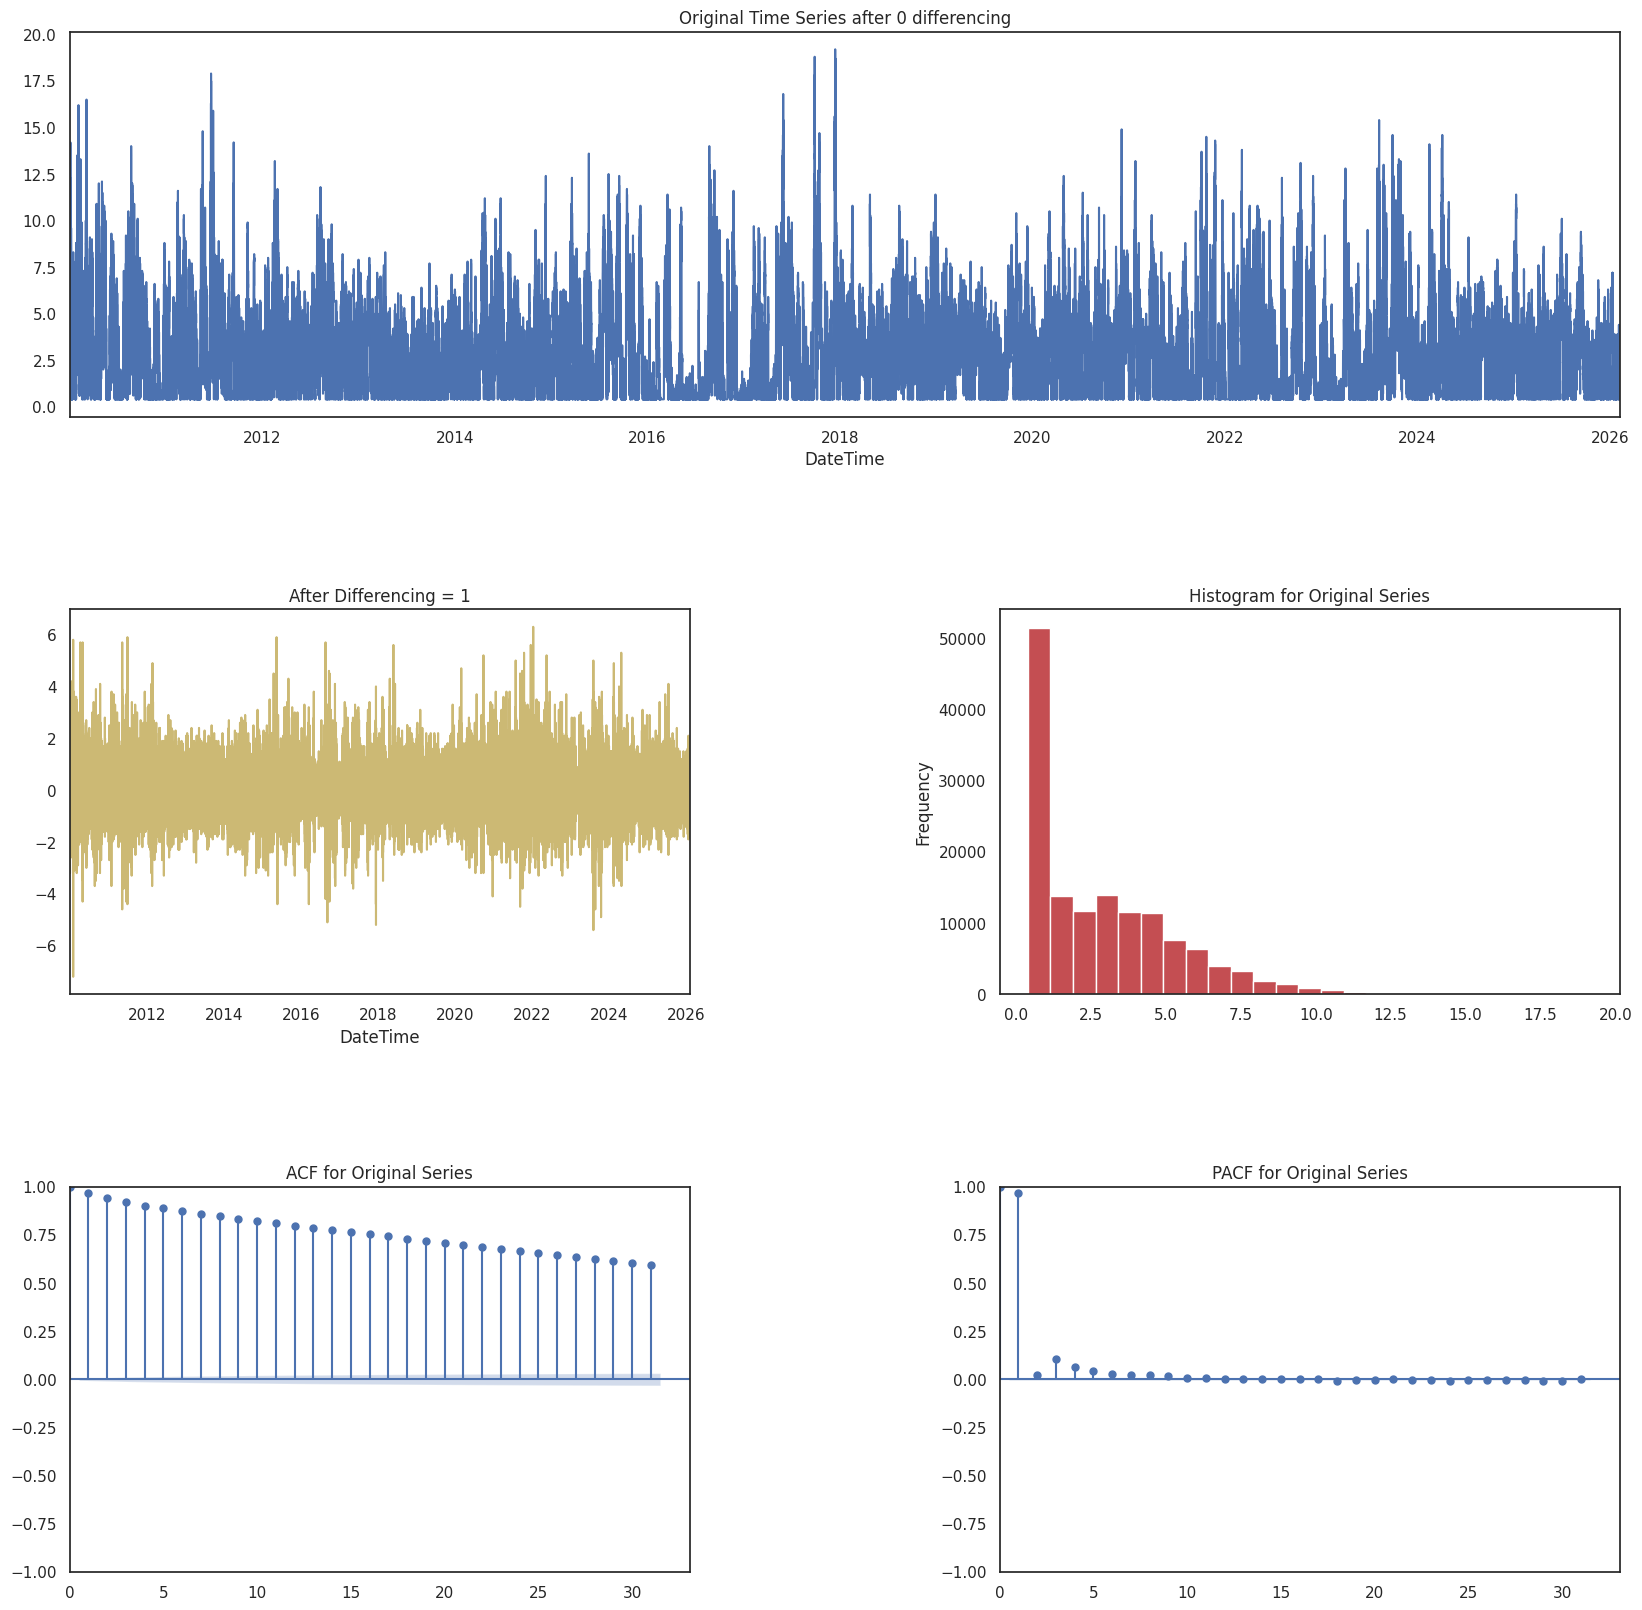

Time Interval is given as H
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(141119, 10)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 141094 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/h_6jjomf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/sy42uf0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20933', 'data', 'file=/tmp/tmpsgg85bzq/h_6jjomf.json', 'init=/tmp/tmpsgg85bzq/sy42uf0h.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modeloyo5p3z4/prophet_model-20240603104024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
10:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 1.89
    Std Deviation of actuals = 0.22
    Normalized RMSE (as pct of std dev) = 843%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 141099 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/hmv2k3ce.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/fip0dlte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97377', 'data', 'file=/tmp/tmpsgg85bzq/hmv2k3ce.json', 'init=/tmp/tmpsgg85bzq/fip0dlte.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelvx2uk5ig/prophet_model-20240603104121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
10:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 1.49
    Std Deviation of actuals = 0.14
    Normalized RMSE (as pct of std dev) = 1052%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 141104 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/9ormztg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/c_qf612q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75012', 'data', 'file=/tmp/tmpsgg85bzq/9ormztg1.json', 'init=/tmp/tmpsgg85bzq/c_qf612q.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelq82b7_x6/prophet_model-20240603104217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
10:42:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 2.16
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 141109 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/y11botmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/asl6238e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71289', 'data', 'file=/tmp/tmpsgg85bzq/y11botmy.json', 'init=/tmp/tmpsgg85bzq/asl6238e.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelzivy63w_/prophet_model-20240603104310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 1.98
    Std Deviation of actuals = 0.18
    Normalized RMSE (as pct of std dev) = 1105%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 141114 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/jt2q88va.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/50byn97z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22277', 'data', 'file=/tmp/tmpsgg85bzq/jt2q88va.json', 'init=/tmp/tmpsgg85bzq/50byn97z.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelklznry7y/prophet_model-20240603104404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
10:44:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:44:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 2.34
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 1.97
    MSE (Mean Squared Error = 3.97
    MAPE (Mean Absolute Percent Error) = 406%
    RMSE (Root Mean Squared Error) = 1.9919
    Normalized RMSE (MinMax) = 249%
    Normalized RMSE (as Std Dev of Actuals)= 744%
Time Taken = 276 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/n7kf89_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsgg85bzq/38fszm6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64749', 'data', 'file=/tmp/tmpsgg85bzq/n7kf89_h.json', 'init=/tmp/tmpsgg85bzq/38fszm6g.json', 'output', 'file=/tmp/tmpsgg85bzq/prophet_modelgbzckmcr/prophet_model-20240603104500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
10:45:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:45:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 141094 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 261881.563
Static Forecasts:
    RMSE = 0.21
    Std Deviation of Actuals = 0.22
    Normalized RMSE (as pct of std dev) = 92.0%

Fold Number: 2 --> Train Shape: 141099 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 261886.526
Static Forecasts:
    RMSE = 0.15
    Std Deviation of Actuals = 0.14
    Normalized RMSE (as pct of std dev) = 109.4%

Fold Number: 3 --> Train Shape: 141104 Test Shape: 5

    Find

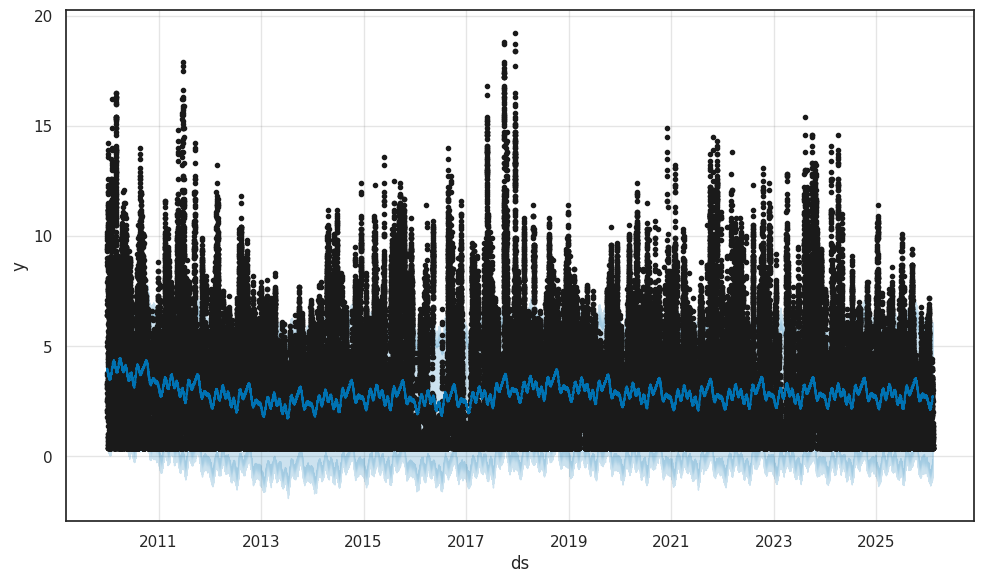

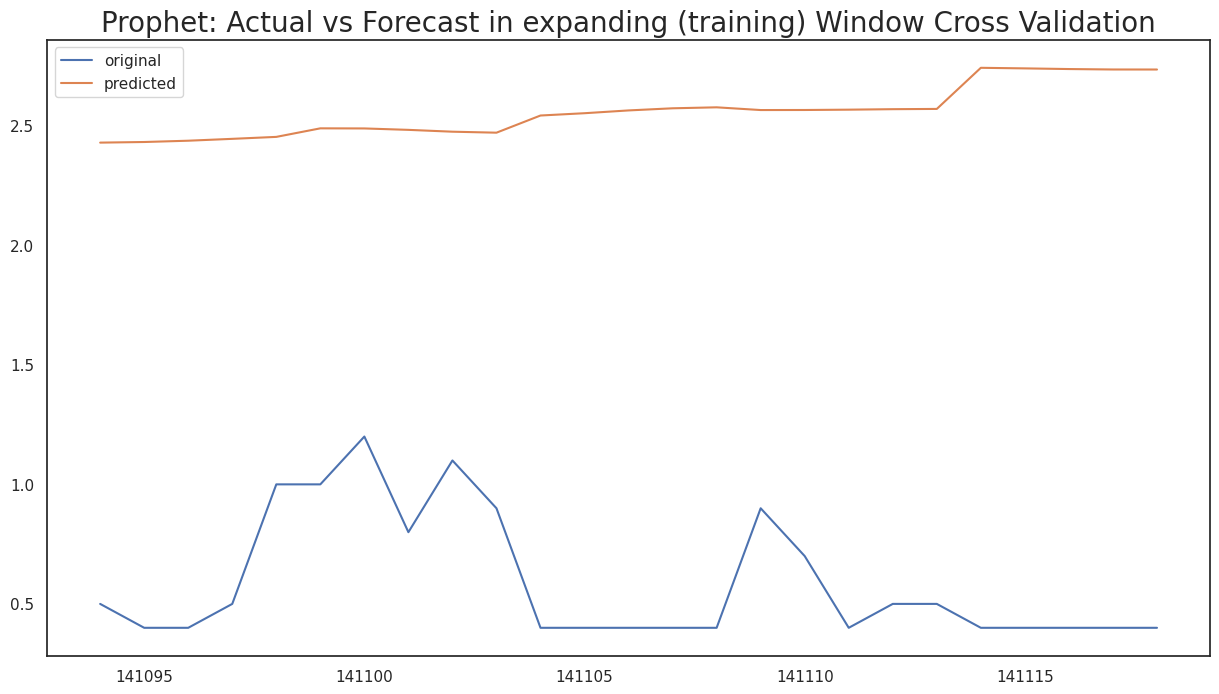

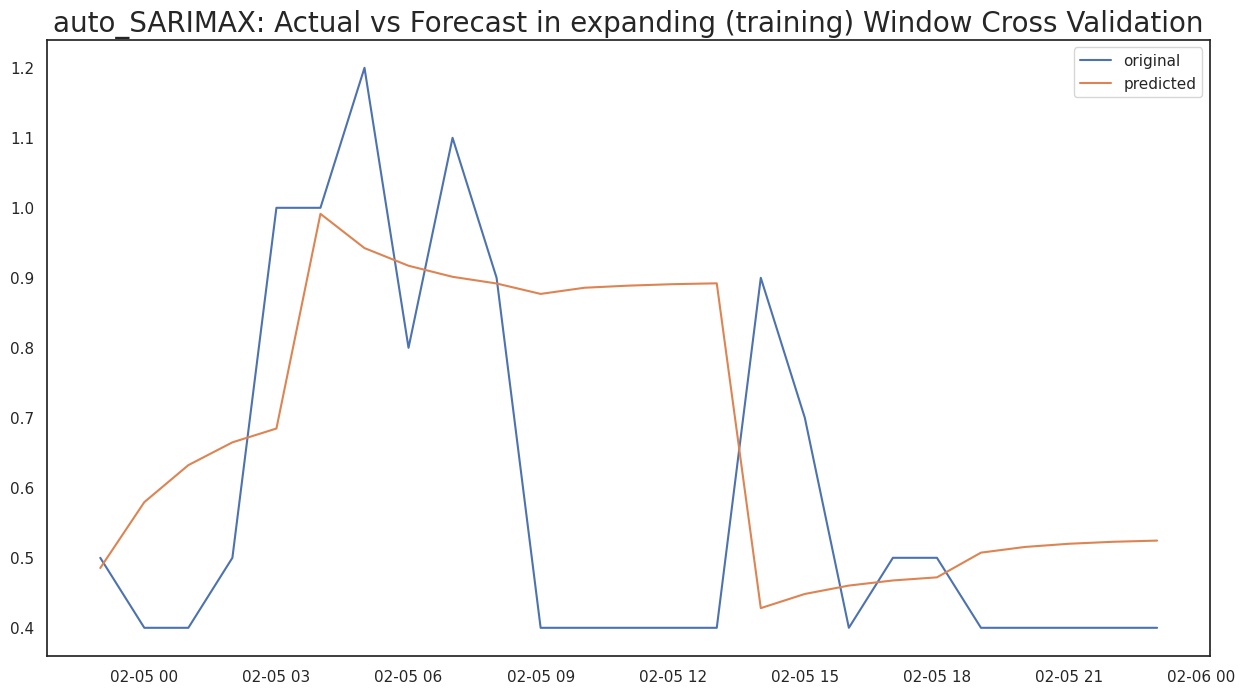

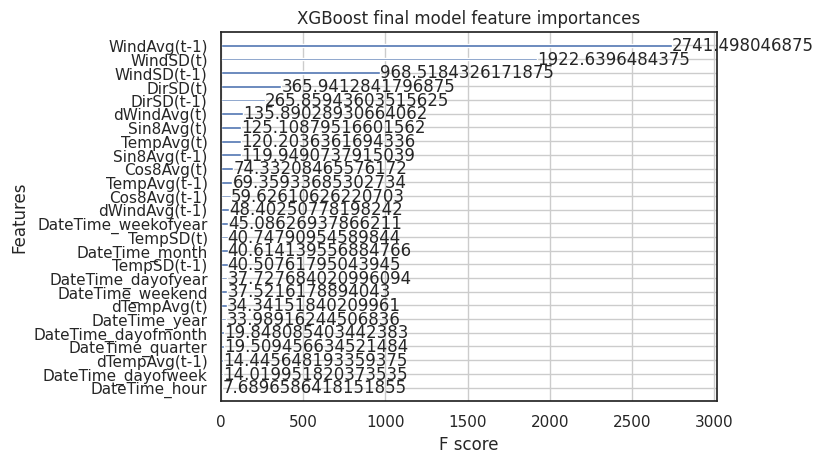

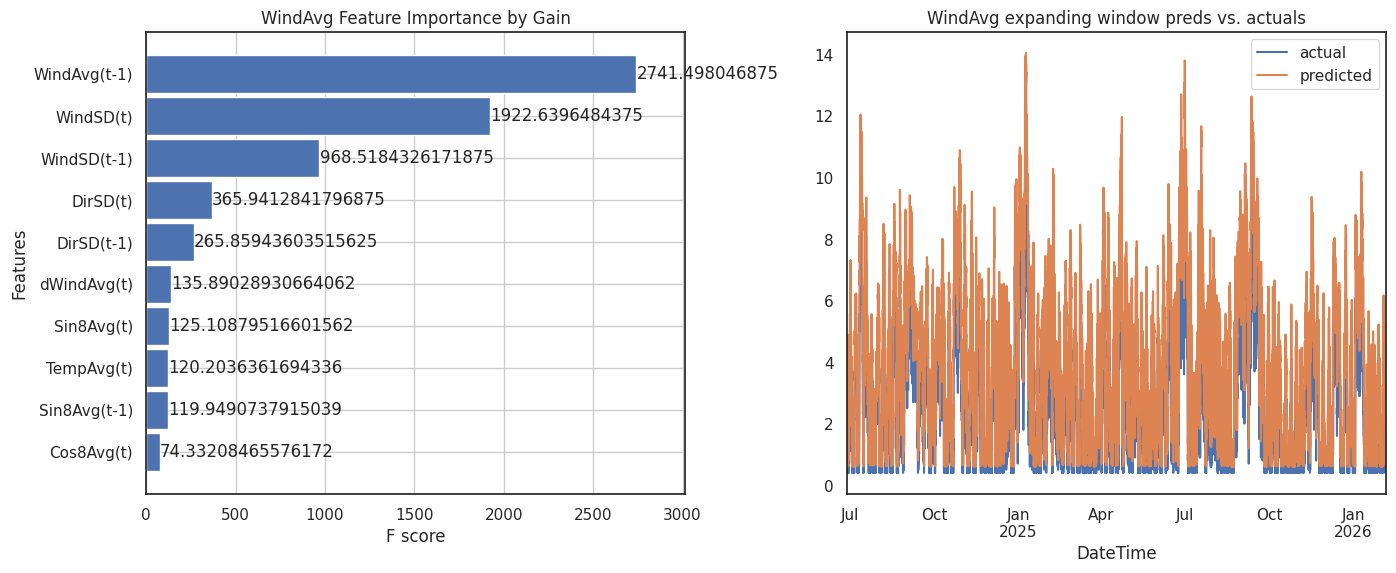

In [ ]:
model4 = auto_timeseries(score_type='rmse',   # функция потерь
                        time_interval='H',   # дневной интервал
                        model_type='best',   # сохраняем лучшую модель
                        verbose=1)
train4, val4 = data4.iloc[1:141120], data4.iloc[141120:]
model4.fit(traindata=train4,      # на выборке train
          ts_column='DateTime',   # колонка с временными отсчетами
          target='WindAvg')

In [ ]:
model4.get_leaderboard()

name      rmse
1  auto_SARIMAX  0.241552
2            ML  1.505734
0       Prophet  1.971164

Predicting using test dataframe shape = (288, 10) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for DateTime. Provide strf_time format during "setup" for better results.
ML predictions completed


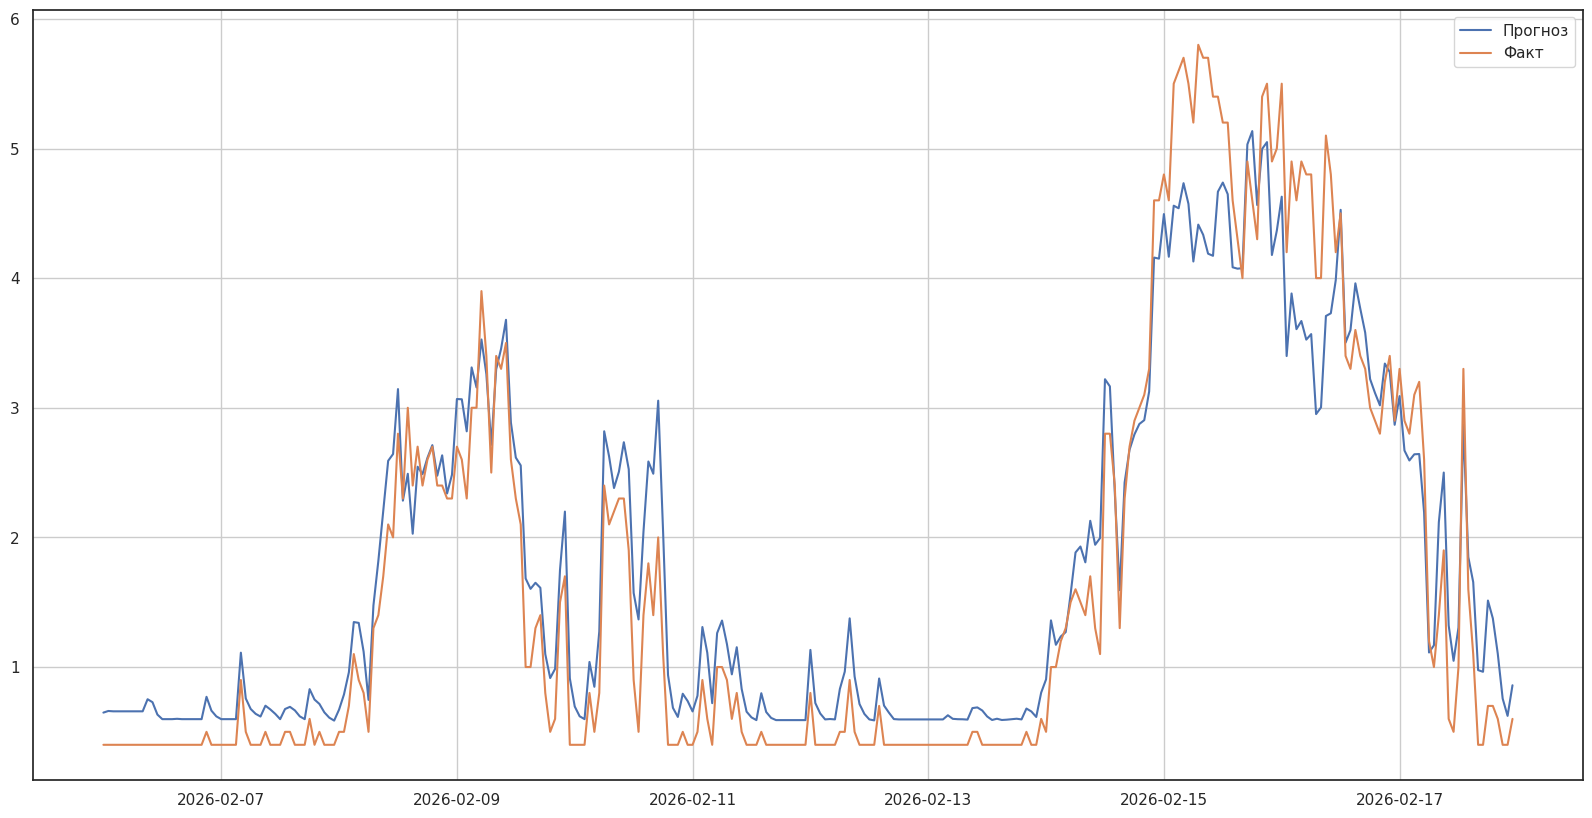

In [ ]:
pred4 = model4.predict(val4, model='ML')['yhat'].to_numpy(float)
plt.figure(figsize=(20, 10))
plt.plot(val4['DateTime'], pred4, label='Прогноз')
plt.plot(val4['DateTime'], val4['WindAvg'], label='Факт')
plt.legend()
plt.grid()
plt.show()

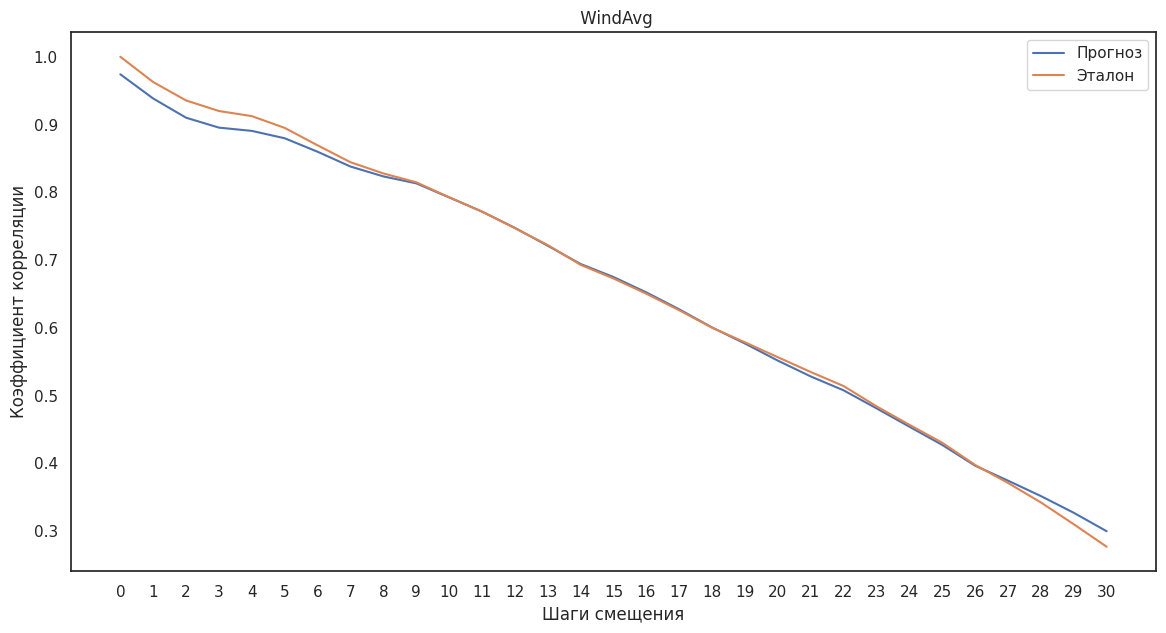

In [ ]:
show_corr(pred4, val4['WindAvg'], # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['WindAvg'],
              title='')

###Эксперимент 5

Для проверки предположения, что именно добавление производных убирает автокорреляцию, проведем эксперимент по вышке Палана с данными без производных

In [ ]:
data5 = data4[['DateTime','WindAvg','WindSD','Sin8Avg','Cos8Avg','DirSD','TempAvg','TempSD']].copy(deep=True).reset_index()
del data5['index']
data5

DateTime  WindAvg  WindSD   Sin8Avg   Cos8Avg     DirSD  \
0      2010-01-01 00:00:00      2.1     1.2  0.951057 -0.309017  0.990268   
1      2010-01-01 01:00:00      2.6     1.3  0.069756 -0.997564  0.874620   
2      2010-01-01 02:00:00      2.1     0.9 -0.438371  0.898794  0.681998   
3      2010-01-01 03:00:00      3.1     1.3 -0.190809  0.981627  0.292372   
4      2010-01-01 04:00:00      3.3     1.0 -0.104528  0.994522  0.374607   
...                    ...      ...     ...       ...       ...       ...   
141403 2026-02-17 19:00:00      0.7     0.4 -0.681998  0.731354  0.997564   
141404 2026-02-17 20:00:00      0.6     0.3 -0.998630  0.052336  0.681998   
141405 2026-02-17 21:00:00      0.4     0.1 -0.052336  0.998630  0.390731   
141406 2026-02-17 22:00:00      0.4     0.0  0.087156  0.996195  0.000000   
141407 2026-02-17 23:00:00      0.6     0.4  0.017452  0.999848  0.034899   

        TempAvg  TempSD  
0           0.6     0.4  
1           0.9     0.3  
2           0.5     0.1  
3           0.4     0.1  
4           0.5     0.1  
...         ...     ...  
141403      5.6     0.2  
141404      5.6     0.1  
141405      5.7     0.1  
141406      5.5     0.1  
141407      5.8     0.2  

[141408 rows x 8 columns]

Start of Fit.....
    Target variable given as = WindAvg
Start of loading of data.....
    Inputs: ts_column = DateTime, sep = ,, target = ['WindAvg']
    Using given input: pandas dataframe...
    DateTime column exists in given train data...
    train data shape = (141119, 7)
Alert: Could not detect strf_time_format of DateTime. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


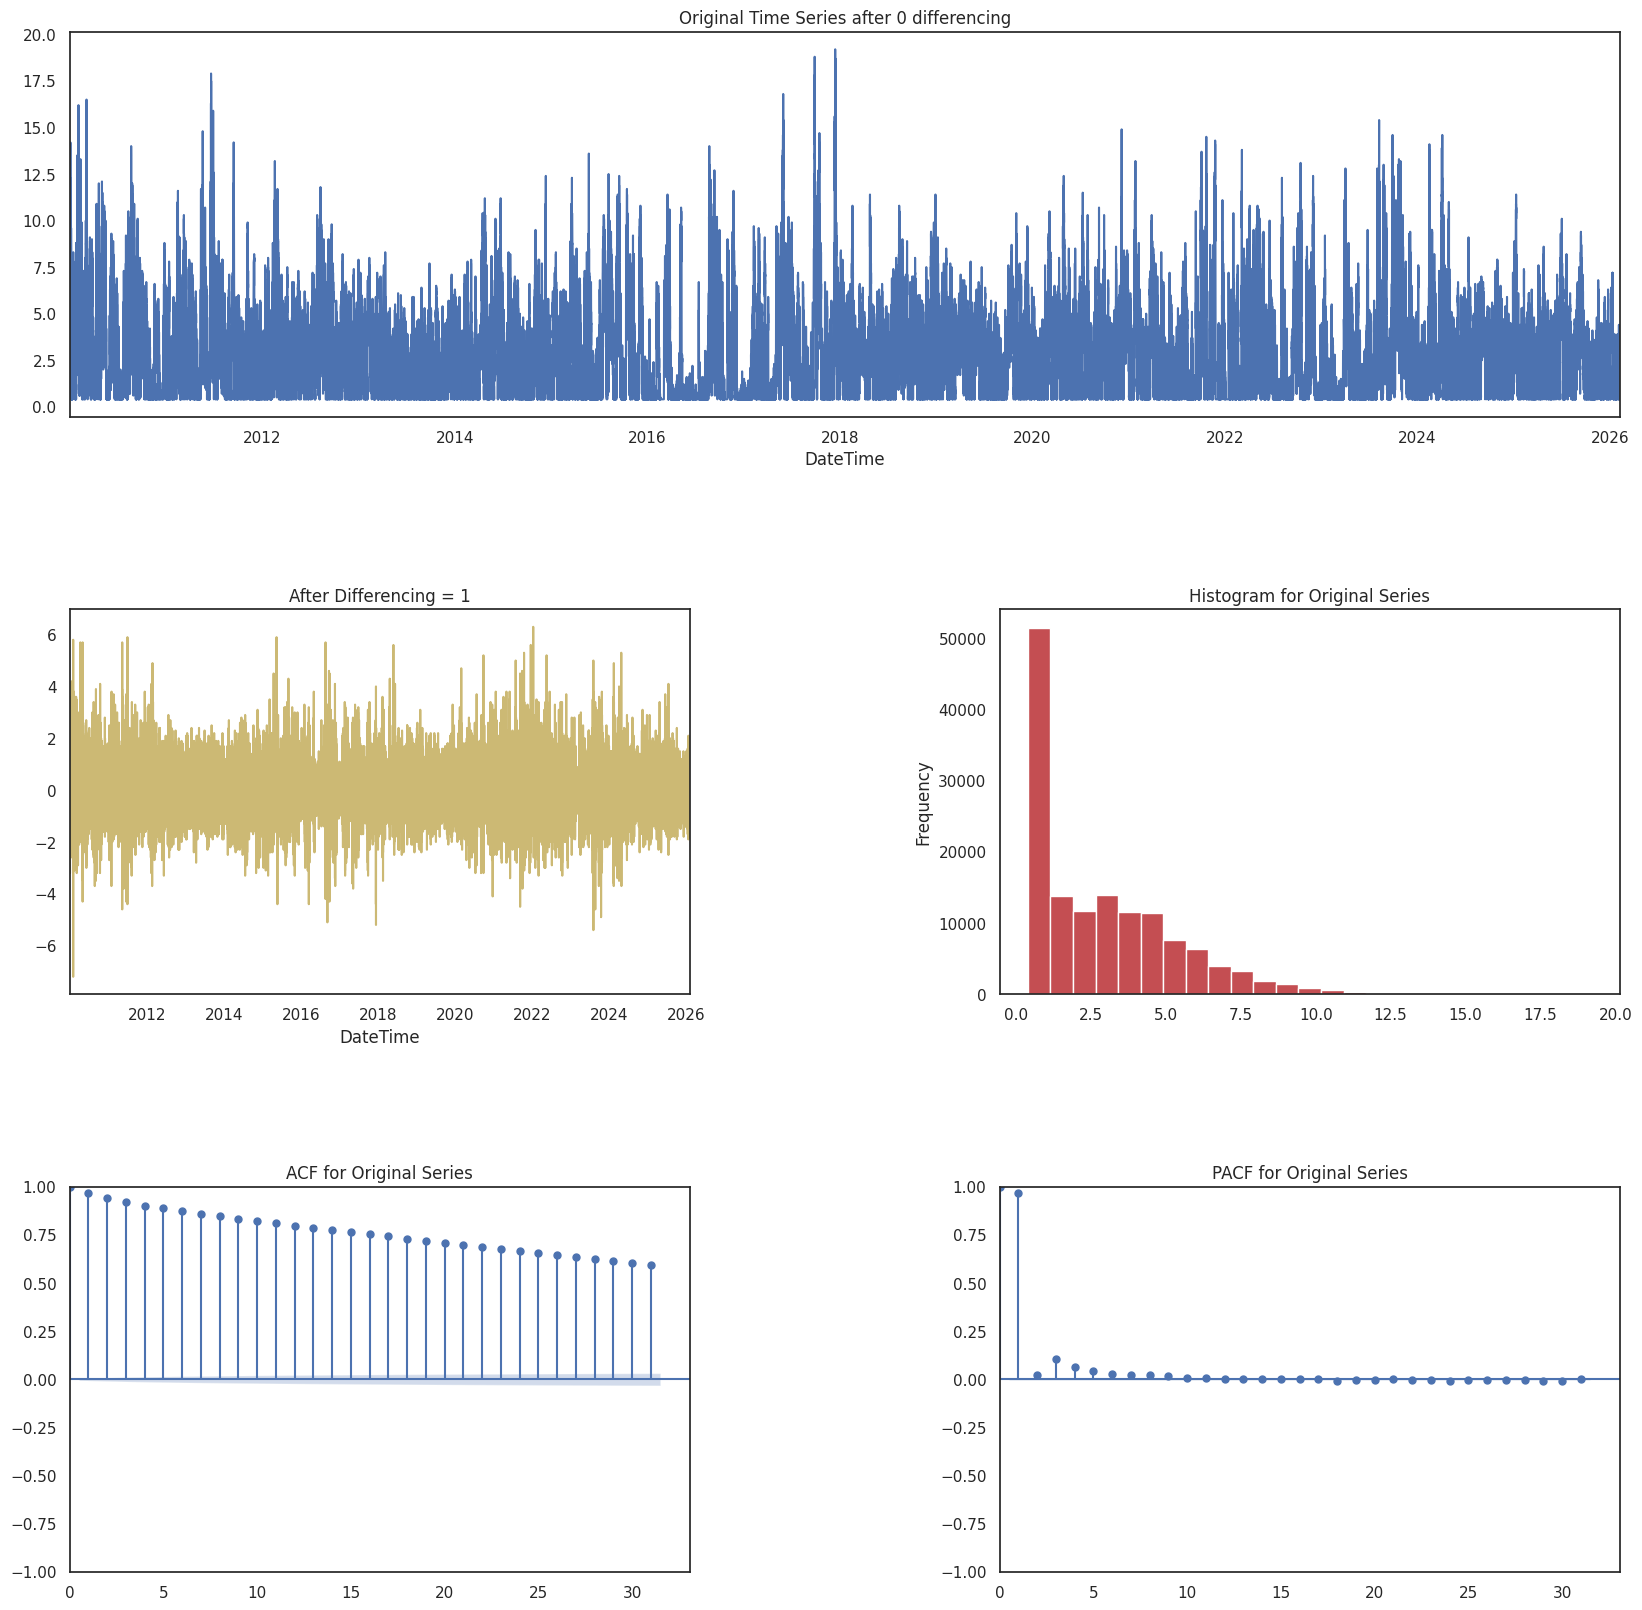

Time Interval is given as H
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(141119, 8)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 141094 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/5bm4klvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/i9961cmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25835', 'data', 'file=/tmp/tmpuci49ioz/5bm4klvl.json', 'init=/tmp/tmpuci49ioz/i9961cmu.json', 'output', 'file=/tmp/tmpuci49ioz/prophet_model7n9a4hlj/prophet_model-20240603145140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
14:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 1.89
    Std Deviation of actuals = 0.22
    Normalized RMSE (as pct of std dev) = 843%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 141099 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/htl88r23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/ohdodnp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91022', 'data', 'file=/tmp/tmpuci49ioz/htl88r23.json', 'init=/tmp/tmpuci49ioz/ohdodnp9.json', 'output', 'file=/tmp/tmpuci49ioz/prophet_model0hsccgq3/prophet_model-20240603145235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
14:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 1.49
    Std Deviation of actuals = 0.14
    Normalized RMSE (as pct of std dev) = 1052%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 141104 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/u3i8it0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/e6pmx1r2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59927', 'data', 'file=/tmp/tmpuci49ioz/u3i8it0s.json', 'init=/tmp/tmpuci49ioz/e6pmx1r2.json', 'output', 'file=/tmp/tmpuci49ioz/prophet_modelmb8yptri/prophet_model-20240603145331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 2.16
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 141109 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/mb7jsypj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/v_pwhnwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33173', 'data', 'file=/tmp/tmpuci49ioz/mb7jsypj.json', 'init=/tmp/tmpuci49ioz/v_pwhnwm.json', 'output', 'file=/tmp/tmpuci49ioz/prophet_modele3xp2jzo/prophet_model-20240603145425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
14:54:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:54:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 1.98
    Std Deviation of actuals = 0.18
    Normalized RMSE (as pct of std dev) = 1105%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 141114 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/rfe0ch81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/docrlqzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33244', 'data', 'file=/tmp/tmpuci49ioz/rfe0ch81.json', 'init=/tmp/tmpuci49ioz/docrlqzb.json', 'output', 'file=/tmp/tmpuci49ioz/prophet_modelqombtk3c/prophet_model-20240603145523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 2.34
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 1.97
    MSE (Mean Squared Error = 3.97
    MAPE (Mean Absolute Percent Error) = 406%
    RMSE (Root Mean Squared Error) = 1.9919
    Normalized RMSE (MinMax) = 249%
    Normalized RMSE (as Std Dev of Actuals)= 744%
Time Taken = 280 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/wu571ov2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuci49ioz/gbx81g2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1963', 'data', 'file=/tmp/tmpuci49ioz/wu571ov2.json', 'init=/tmp/tmpuci49ioz/gbx81g2y.json', 'output', 'file=/tmp/tmpuci49ioz/prophet_modelg6crfjyh/prophet_model-20240603145620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
14:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 141094 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 261881.563
Static Forecasts:
    RMSE = 0.21
    Std Deviation of Actuals = 0.22
    Normalized RMSE (as pct of std dev) = 92.0%

Fold Number: 2 --> Train Shape: 141099 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,1,2)*(0,0,0,12), aic = 261886.526
Static Forecasts:
    RMSE = 0.15
    Std Deviation of Actuals = 0.14
    Normalized RMSE (as pct of std dev) = 109.4%

Fold Number: 3 --> Train Shape: 141104 Test Shape: 5

    Find

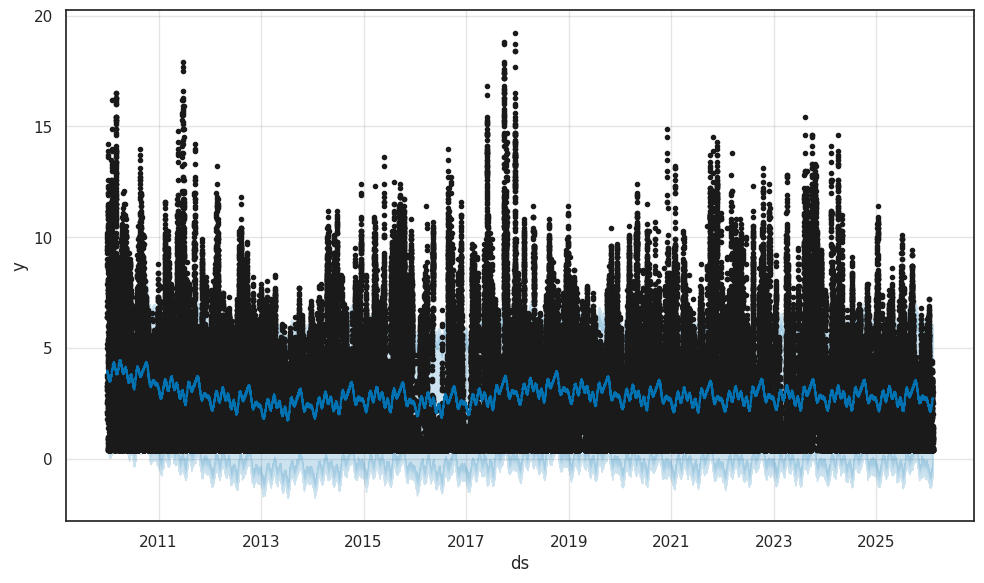

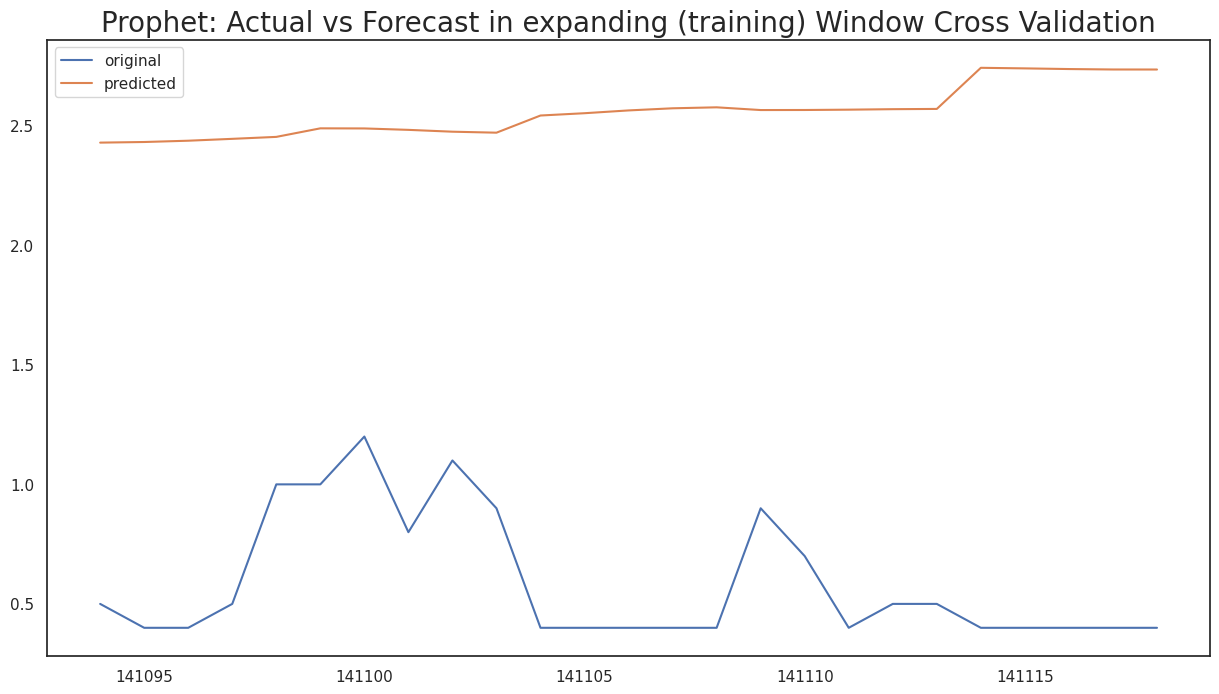

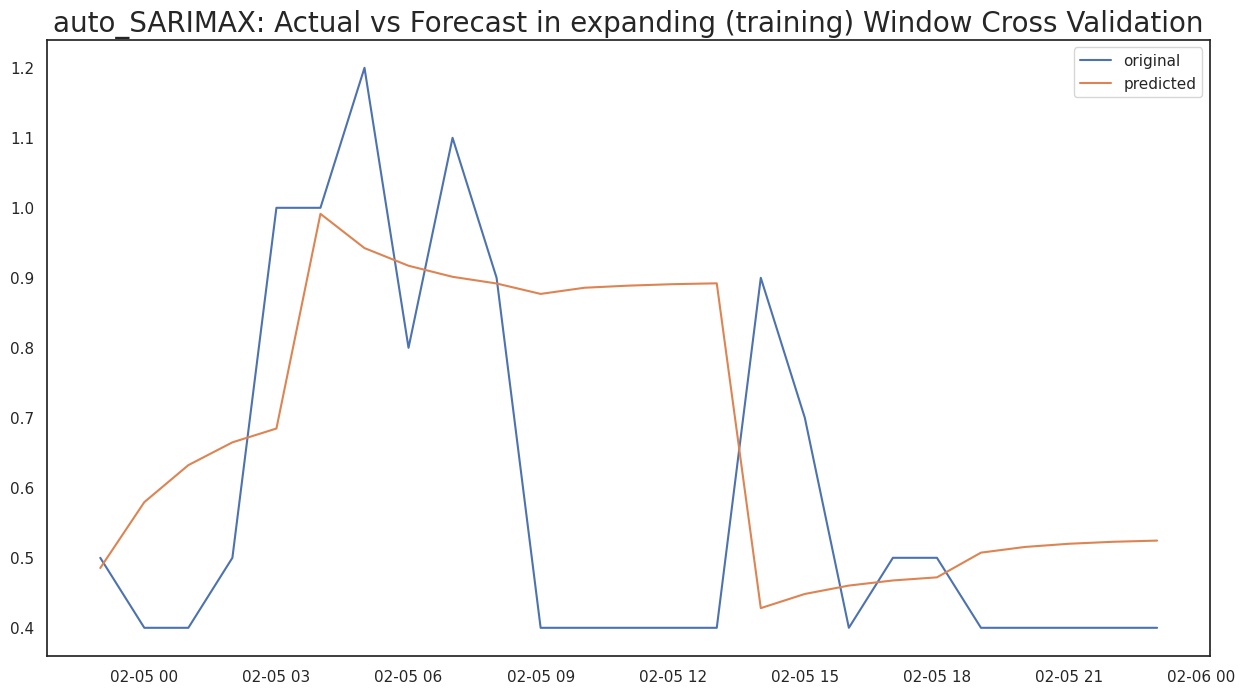

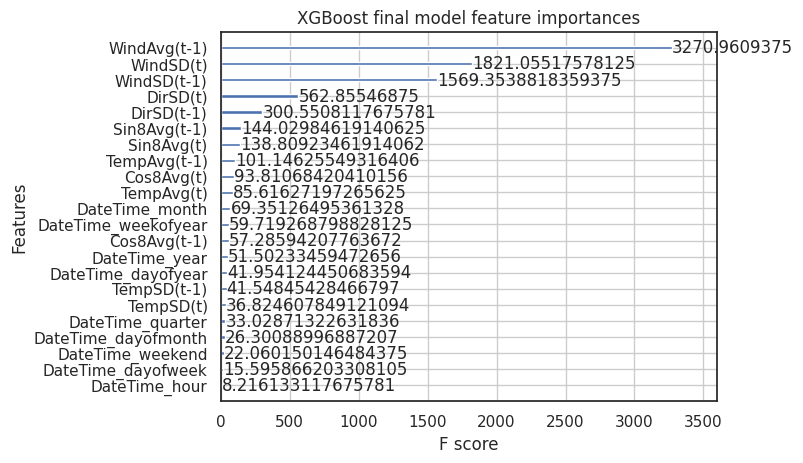

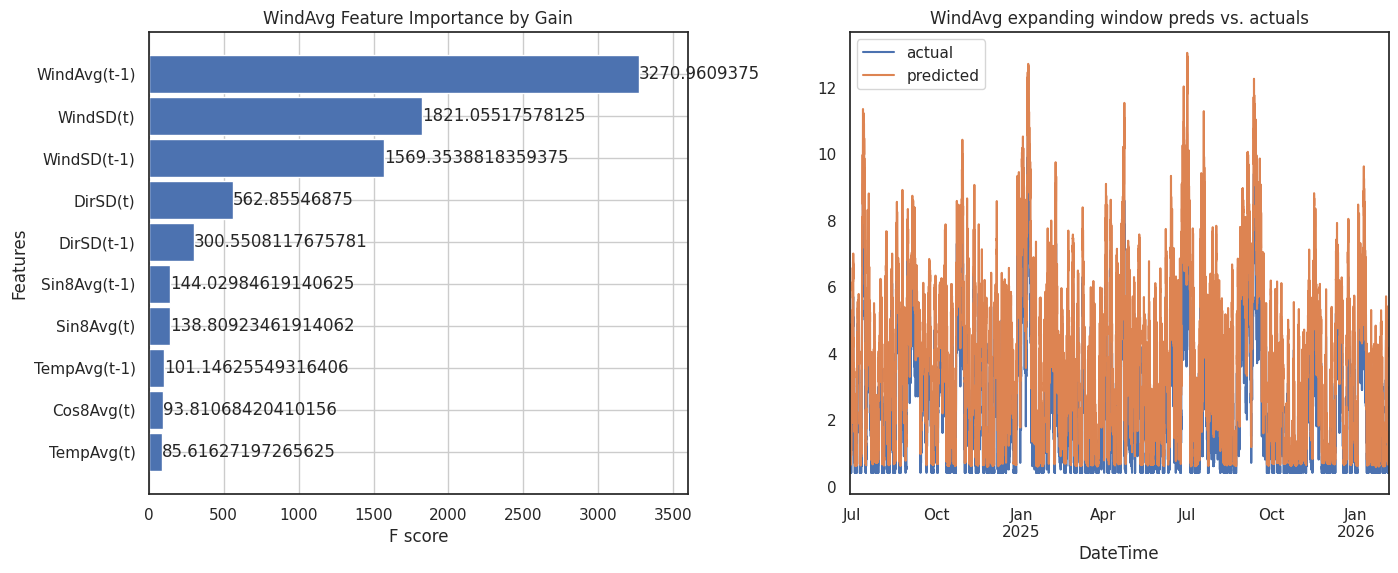

In [ ]:
model5 = auto_timeseries(score_type='rmse',   # функция потерь
                        time_interval='H',   # дневной интервал
                        model_type='best',   # сохраняем лучшую модель
                        verbose=1)
train5, val5 = data5.iloc[1:141120], data5.iloc[141120:]
model5.fit(traindata=train5,      # на выборке train
          ts_column='DateTime',   # колонка с временными отсчетами
          target='WindAvg')

In [ ]:
model5.get_leaderboard()

name      rmse
1  auto_SARIMAX  0.241552
2            ML  1.425560
0       Prophet  1.971164

Predicting using test dataframe shape = (288, 8) for ML model
For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    Using given input: pandas dataframe...
    Alert: No strf_time_format given for DateTime. Provide strf_time format during "setup" for better results.
ML predictions completed


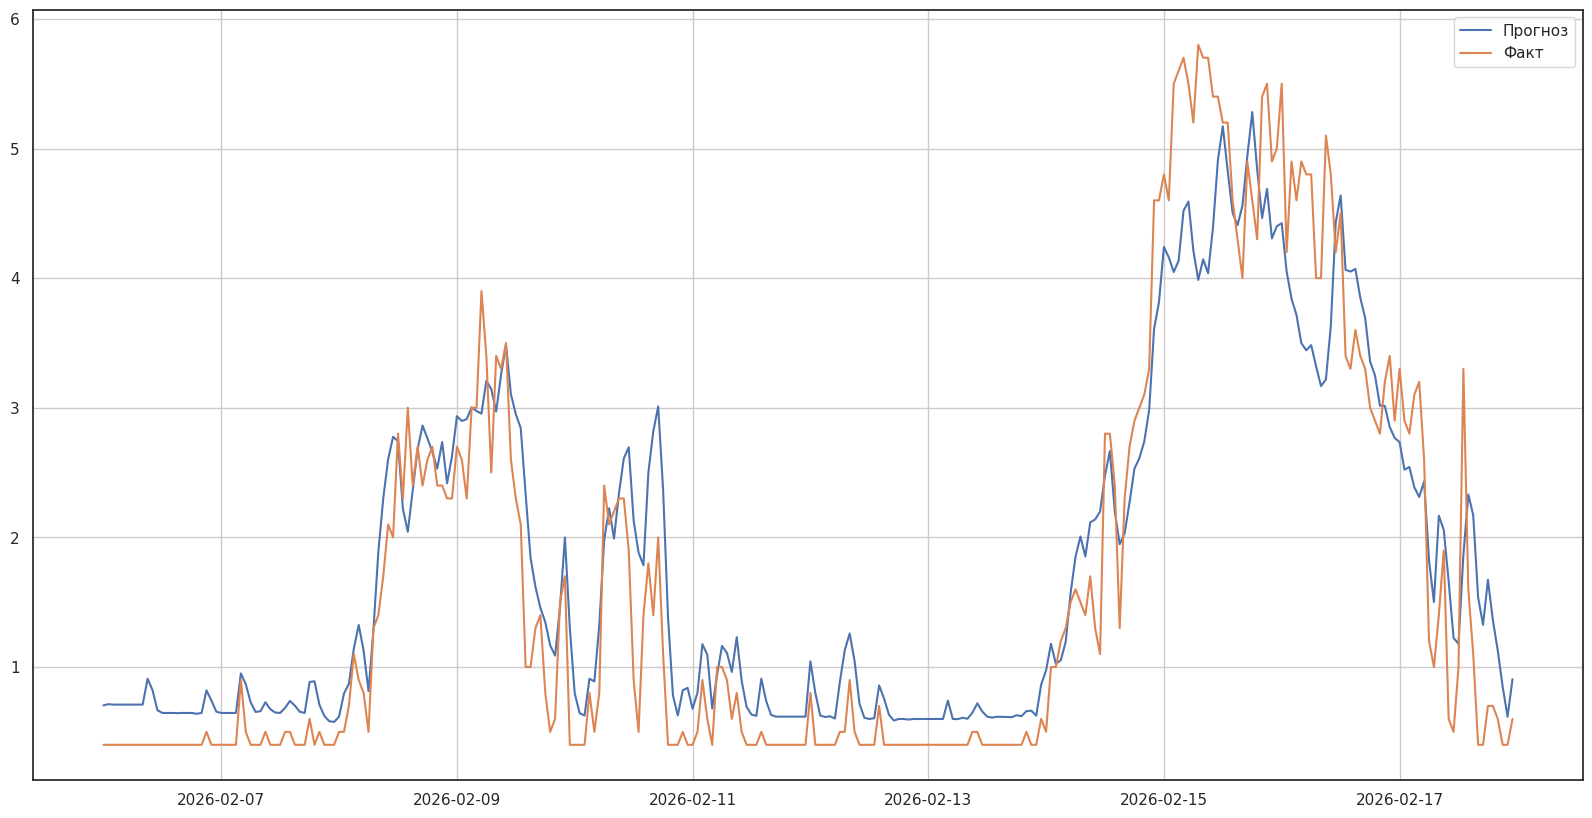

In [ ]:
pred5 = model5.predict(val5, model='ML')['yhat'].to_numpy(float)
plt.figure(figsize=(20, 10))
plt.plot(val5['DateTime'], pred5, label='Прогноз')
plt.plot(val5['DateTime'], val5['WindAvg'], label='Факт')
plt.legend()
plt.grid()
plt.show()

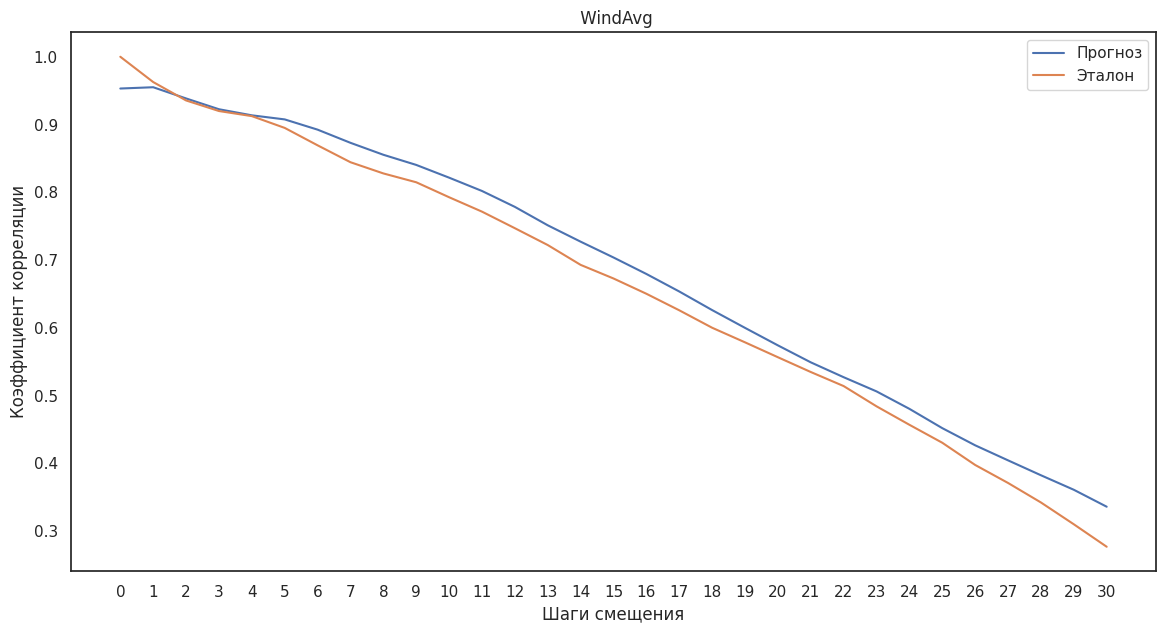

In [ ]:
show_corr(pred5, val5['WindAvg'], # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['WindAvg'],
              title='')

Вывод:добавление производных в набор данных позволяет избежать появление автокорреляции и получить с помощью auto-ts модель, достаточно хорошо предсказывающую скорость ветра